# Evaluation of trained network for temporal super-resolution on paired datasets (mostly in-silico)

This notebook provides an evaluation framework to evaluate one network considering quantitative and qualitative analysis. 
Quantitatively this includes corelation plots and its parameters, relative error, rmse and many more

In [2]:
#%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from IPython.display import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import matplotlib.cm as cm
import matplotlib.image as mpimg
import sys

sys.path.append("../../src")
plt.rcParams['figure.figsize'] = [10, 8]
%matplotlib inline

from utils.colors import *
from utils.evaluate_utils import *

In [3]:
df = pd.read_csv('../../results/Overview_models.csv')
df1 = df[['Name', 'notes']]
pd.set_option("max_colwidth", None)
display(df1)

,Name,notes
0,Temporal4DFlowNet_20230210-0333,NaN
1,Temporal4DFlowNet_20230215-1029,NaN
2,Temporal4DFlowNet_20230217-0602,NaN
3,Temporal4DFlowNet_20230220-0908,NaN
4,Temporal4DFlowNet_20230301-1127,First training on radial sampled data
...,...,...
94,Temporal4DFlowNet_20240215-1615,"Toeger data, mutual. proj. loss (0.5, a = 0.5) and mse (0.5)"
95,Temporal4DFlowNet_20240223-1140,"Box data, mse"
96,Temporal4DFlowNet_20240226-2026,"Box data, mse, random (flower) magnitude"
97,Temporal4DFlowNet_20240314-1455,"Toeger, mse, random (flower) magnitude now 3D rotated"


### Define model and dataset to evaluate


In [4]:
# Define directories and filenames

model_name = '20240314-1514' #'20230602-1701'#'20230308-1226'#'20230404-1418'#'20230313-0948'#'20230301-1641'  #'20230308-1226'# #'#'20230308-1226' #'20230301-1641'  '20230301-1654', '20230301-1704'
set_name = 'Test'               
data_model = '4'
step = 2

add_ending = '2'#'_newmag'#''#'_newmag'

use_dynamical_mask = True
offset = False

include_interpolationfiles = False

#TODO S: 
"""
- take functions into evaluation utils
- tidy up mean speed calculation
- idy up plane 3d plot
- todo: dynamic mask neede if mask is made dynamic??
- make correlation plot faster; e.g. give random indices to function as option
- different colors for plots
"""

'\n- take functions into evaluation utils\n- tidy up mean speed calculation\n- idy up plane 3d plot\n- todo: dynamic mask neede if mask is made dynamic??\n- make correlation plot faster; e.g. give random indices to function as option\n- different colors for plots\n'

### Load data


In [5]:
vel_colnames=['u', 'v', 'w']
vel_colnames_fluid = ['u_fluid', 'v_fluid', 'w_fluid']

def load_data(model_name, set_name, data_model, step,dynamic_mask_used, ending_file= ''):
    #directories
    gt_dir = '../../data/CARDIAC'
    result_dir = f'../../results/Temporal4DFlowNet_{model_name}'
    eval_dir = f'{result_dir}/plots'
    lr_dir = '../../data/CARDIAC'

    inbetween_string = ''
    add_offset = ''
    if dynamic_mask_used:
        inbetween_string = '_dynamic'
    if offset:
        print('LR is now sampled with offset of 1')
        add_offset = '_offset1'
        offset_val = 1
    else:
        offset_val = 0

    #/home/pcallmer/Temporal4DFlowNet/data/CARDIAC/M4_2mm_step2_invivoP02_magnitude_adapted_noisy.h5
    #filenames

    lr_filename = f'M{data_model}_2mm_step{step}_cloudmagnRot_toeger_LRfct_noise.h5'
    gt_filename = f'M{data_model}_2mm_step{step}_cloudmagnRot_toeger_HRfct.h5'
    # gt_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}.h5'
    # lr_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}_noise.h5' #_noise
    # gt_filename = f'M{data_model}_2mm_step{step}_invivoP02_magnitude.h5'
    # lr_filename = f'M{data_model}_2mm_step{step}_invivoP02_magnitude_noisy.h5'
    # gt_filename = f'M{data_model}_2mm_step{step}_invivoP01_magnitude.h5'
    # lr_filename = f'M{data_model}_2mm_step{step}_invivoP01_magnitude_noisy.h5'

    result_filename = f'{set_name}set_result_model{data_model}_2mm_step{step}_{model_name[-4::]}_temporal{ending_file}{add_offset}.h5' #_newpadding
    evaluation_filename = f'eval_rel_err_{data_model}_2mm_step{step}_{model_name[-4::]}_temporal.h5'

    print(gt_filename, lr_filename)

    if not os.path.isdir(eval_dir):
        os.makedirs(eval_dir)

    #Params for evalation
    save_relative_error_file= False

    # Setting up
    gt_filepath = '{}/{}'.format(gt_dir, gt_filename)
    res_filepath = '{}/{}'.format(result_dir, result_filename)
    lr_filepath = '{}/{}'.format(lr_dir, lr_filename)
    

    if save_relative_error_file:
        assert(not os.path.exists(f'{result_dir}/{evaluation_filename}')) #STOP if relative error file is already created

    
    gt = {}
    lr = {}
    pred = {}

    with h5py.File(res_filepath, mode = 'r' ) as h_pred:
        with h5py.File(gt_filepath, mode = 'r' ) as h_gt:
            with h5py.File(lr_filepath, mode = 'r' ) as h_lr:
                print("shapes:", h_pred['u_combined'].shape, h_gt['u'].shape, h_lr['u'].shape)
                
                gt["mask"] = np.asarray(h_gt["mask"]).squeeze()
                gt["mask"][np.where(gt["mask"] !=0)] = 1
                if len(gt['mask'].shape) == 4 : # check for dynamical mask, otherwise create one
                    dynamic_mask = gt['mask'].copy()
                else:
                    print('Create static temporal mask for model')
                    dynamic_mask = create_dynamic_mask(gt["mask"], h_gt['u'].shape[0])
                gt['mask'] = dynamic_mask.copy()
                lr['mask'] = dynamic_mask[offset_val::2, :, :, :].copy()
                print(gt['mask'].shape)

                # adapt dimension
                for vel in vel_colnames:
                    
                    gt[vel] = np.asarray(h_gt[vel])
                    pred[vel] = np.asarray(h_pred[f'{vel}_combined'])   
                    lr[vel] = np.asarray(h_lr[vel])[offset_val::2, :, :, :]       

                    # add information considering only the fluid regions  
                    pred[f'{vel}_fluid'] =np.multiply(pred[vel], dynamic_mask)
                    lr[f'{vel}_fluid'] =  np.multiply(lr[vel], lr['mask'])
                    gt[f'{vel}_fluid'] =  np.multiply(gt[vel], dynamic_mask)

                    
                #include speed calculations
                gt['speed']   = np.sqrt(gt["u"]**2 + gt["v"]**2 + gt["w"]**2)
                lr['speed']   = np.sqrt(lr["u"]**2 + lr["v"]**2 + lr["w"]**2)
                pred['speed'] = np.sqrt(pred["u"]**2 + pred["v"]**2 + pred["w"]**2)

                gt['speed_fluid']   = np.multiply(gt['speed'], dynamic_mask)
                lr['speed_fluid']   = np.multiply(lr['speed'], lr['mask'])
                pred['speed_fluid'] = np.multiply(pred['speed'], dynamic_mask)


    return lr, gt, pred, dynamic_mask, eval_dir

def load_interpolation(data_model, step, lr, gt, use_dynamical_mask):
    """Load interpolation files (nearest neighbor, linear, cubic) or calculate them if they do not exist """
    
    interpolate_NN = {}
    interpolate_linear = {}
    interpolate_cubic = {}


    inbetween_string = ''
    if use_dynamical_mask:
        inbetween_string = '_dynamic'

    lr_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}_noise.h5'


    interpolation_file= f'../results/interpolation/{lr_filename[:-3]}_interpolation'
    if not os.path.isfile(interpolation_file):
        print("Interpolation file does not exist - calculate interpolation and save files")
        print("Save interpolation files to: ", interpolation_file)
        
        #this can take a while
        for vel in vel_colnames:
            print("Interpolate low resolution images - ", vel)
            print(gt['mask'].shape)
            interpolate_linear[vel] = temporal_linear_interpolation(lr[vel], gt[vel].shape)
            interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], gt['mask'])

            interpolate_cubic[vel] = temporal_cubic_interpolation(lr[vel], gt[vel].shape)
            interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], gt['mask'])

            interpolate_NN[vel] = temporal_NN_interpolation(lr[vel], gt[vel].shape)
            interpolate_NN[f'{vel}_fluid'] = np.multiply(interpolate_NN[vel], gt['mask'])

            prediction_utils.save_to_h5(interpolation_file, f'linear_{vel}' , interpolate_linear[vel], compression='gzip')
            prediction_utils.save_to_h5(interpolation_file, f'cubic_{vel}' , interpolate_cubic[vel], compression='gzip')
            prediction_utils.save_to_h5(interpolation_file, f'NN_{vel}' , interpolate_NN[vel], compression='gzip')
    else:
        print("Load existing interpolation file")
        with h5py.File(interpolation_file, mode = 'r' ) as h_interpolate:
            for vel in vel_colnames:
                interpolate_linear[vel] = np.array(h_interpolate[f'linear_{vel}'])
                interpolate_cubic[vel] =  np.array(h_interpolate[f'cubic_{vel}'])
                interpolate_NN[vel] =     np.array(h_interpolate[f'NN_{vel}'])


                interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], gt['mask'])
                interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], gt['mask'])
                interpolate_NN[f'{vel}_fluid'] = np.multiply(interpolate_NN[vel], gt['mask'])

    return interpolate_linear, interpolate_cubic, interpolate_NN

lr, gt, pred, dynamic_mask, eval_dir = load_data(model_name, set_name, data_model, step, use_dynamical_mask, ending_file=add_ending)

M4_2mm_step2_cloudmagnRot_toeger_HRfct.h5 M4_2mm_step2_cloudmagnRot_toeger_LRfct_noise.h5
shapes: (50, 61, 57, 83) (50, 61, 57, 83) (50, 61, 57, 83)
(50, 61, 57, 83)


In [ ]:
def calculate_pseudo_huber_loss( u, v, w, u_pred, v_pred, w_pred, delta= 0.05):
    a = (u_pred - u) + (v_pred-v) + (w_pred-w)
    return delta**2*(np.sqrt(1+(a/delta)**2)-1)

def calculate_l2_loss( u, v, w, u_pred, v_pred, w_pred):
    return (u_pred - u)**2 + (v_pred-v)**2 + (w-w_pred)**2

def calculate_l2_norm(u, v, w):
    return np.sqrt(u**2 + v**2 + w**2)

def calculate_l1_loss( u, v, w, u_pred, v_pred, w_pred):
    return np.abs(u_pred - u) + np.abs(v_pred-v) + np.abs(w_pred- w)

def calculate_huber_loss(u, v, w, u_pred, v_pred, w_pred, delta = 0.05):
    """
        Calculate huberloss depending on delta
    """
    huber_mse = 0.5*((u_pred - u) ** 2 +  (v_pred - v) ** 2 + (w_pred - w) ** 2)
    huber_mae = delta * (np.abs(u_pred - u) + np.abs(v_pred - v) + np.abs(w_pred - w) - 0.5 * delta)
    return np.where(np.abs(u_pred - u) + np.abs(v_pred - v) + np.abs(w_pred - w) <= delta, huber_mse, huber_mae)

def pseudo_huber_loss(a, delta):
      return delta**2*(np.sqrt(1+((a)/delta)**2)-1)

def l2_loss(a):
    return a**2

def l1_loss(a):
    return np.abs(a)

def huber_loss(a, delta):
    return np.where(np.abs(a) <= delta, 0.5*a**2, delta*(np.abs(a)-0.5*delta))

def huber_loss2(a, delta):
    return np.where(np.abs(a) <= delta, 0.5*a**2, delta*(np.abs(a)-0.5*delta))

def calculate_l1_mutually_projected_loss1( u, v, w, u_pred, v_pred, w_pred, alpha= 0.5):
    """
        Calculate L1 mutually projected loss
    """
    eps = 0.00005
    theta = np.arccos((u*u_pred + v*v_pred + w*w_pred) / (calculate_l2_norm(u,v,w) * calculate_l2_norm(u_pred,v_pred,w_pred)+eps))
    proj_l1_u_v = np.abs(calculate_l2_norm(u,v,w) - calculate_l2_norm(u_pred,v_pred,w_pred) * np.cos(theta))
    proj_l1_v_u = np.abs(calculate_l2_norm(u_pred,v_pred,w_pred) - calculate_l2_norm(u,v,w) * np.cos(theta))
    return alpha * proj_l1_u_v + (1-alpha)* proj_l1_v_u


def calculate_l1_mutually_projected_loss2( u, v, w, u_pred, v_pred, w_pred, alpha= 0.5):
    """
        Calculate L1 mutually projected loss
    """
    eps = 0.00005
    theta = (u*u_pred + v*v_pred + w*w_pred) / (calculate_l2_norm(u,v,w) * calculate_l2_norm(u_pred,v_pred,w_pred)+ eps)
    proj_l1_u_v = np.abs(calculate_l2_norm(u,v,w) - calculate_l2_norm(u_pred,v_pred,w_pred) * theta)
    proj_l1_v_u = np.abs(calculate_l2_norm(u_pred,v_pred,w_pred) - calculate_l2_norm(u,v,w) * theta)
    return alpha * proj_l1_u_v + (1-alpha)* proj_l1_v_u

def calculate_l1_mutually_projected_loss( u, v, w, u_pred, v_pred, w_pred, alpha= 0.5):
    """
        Calculate L1 mutually projected loss
    """
    eps = 0.00005
    proj_l1_u_v = np.abs(calculate_l2_norm(u,v,w) - (u*u_pred + v*v_pred + w*w_pred)/ (calculate_l2_norm(u,v,w) + eps))
    proj_l1_v_u = np.abs(calculate_l2_norm(u_pred,v_pred,w_pred) - (u*u_pred + v*v_pred + w*w_pred)/ (calculate_l2_norm(u_pred,v_pred,w_pred) + eps))
    return alpha * proj_l1_u_v + (1-alpha)* proj_l1_v_u


def combined_l1_mutually_projected_loss( u, v, w, u_pred, v_pred, w_pred, weight, alpha= 0.5):
    """
        Calculate L1 mutually projected loss
    """
    l1_mutuall_proj = calculate_l1_mutually_projected_loss(u, v, w, u_pred, v_pred, w_pred, alpha)
    l1 = calculate_l1_loss(u, v, w, u_pred, v_pred, w_pred)
    return weight * l1_mutuall_proj + (1-weight) * l1

deltas = [0.001,  1, 2, 5, 15, 25, 50]
if False: 
    # huber loss calculation
    
    for delta in deltas:
        huber_loss_value = calculate_pseudo_huber_loss(gt['u'], gt['v'], gt['w'], pred['u'], pred['v'], pred['w'], delta= delta)
        plt.plot(np.average(huber_loss_value, axis= (1, 2,3 )), label = f'pseudo huber, delta = {delta}')
        plt.plot(np.average(calculate_huber_loss(gt['u'], gt['v'], gt['w'], pred['u'], pred['v'], pred['w'], delta= delta), axis= (1, 2,3 )),'--',  label = f'huber {delta}')
    plt.plot(np.average(calculate_l2_loss(gt['u'], gt['v'], gt['w'], pred['u'], pred['v'], pred['w']), axis= (1, 2,3 )),'--',  label = f'l2')
    plt.plot(np.average(calculate_l1_loss(gt['u'], gt['v'], gt['w'], pred['u'], pred['v'], pred['w']), axis= (1, 2,3 )),'--',  label = f'l1')
    # plt.plot(np.average(l1_loss, axis= (1, 2,3 )),'--',  label = f'l1')
    plt.xlabel('frames')
    plt.ylabel(f'loss {set_name}')
    plt.legend()
    plt.show()
    

if False: 
    diff = np.linspace(-5, 5, 100)
    for delta in deltas:
        # plt.plot(diff, pseudo_huber_loss(diff, delta) , label = f'pseudo huber {delta}')
        plt.plot(diff, huber_loss2(diff, delta)   ,'--',  label = f'huber {delta}')

    plt.plot(diff, l2_loss(diff), label = 'l2')
    plt.plot(diff, l1_loss(diff), label = 'l1')
    plt.legend()
    plt.xlabel('difference')
    plt.ylabel('loss')

    plt.show()



In [ ]:
# # import numpy as np
# # # calculate l1_mutually_projected_loss
# alpha = 0.5
# l1_mutually_projected_loss  = calculate_l1_mutually_projected_loss(-gt['u'], gt['v'], gt['w'], pred['u'], pred['v'], pred['w'], alpha= alpha)
# l1_mutually_projected_loss2 = calculate_l1_mutually_projected_loss2(-gt['u'], gt['v'], gt['w'], pred['u'], pred['v'], pred['w'], alpha= alpha)

# l1 = calculate_l1_loss(gt['u'], gt['v'], gt['w'], pred['u'], pred['v'], pred['w'])
# l1_test = calculate_l1_loss(-gt['u'], gt['v'], gt['w'], pred['u'], pred['v'], pred['w'])
# plt.plot(np.average(l1_mutually_projected_loss, axis= (1, 2,3 )), label = f'l1_mutually_projected_loss')
# plt.plot(np.average(l1_mutually_projected_loss2, axis= (1, 2,3 )),'--',  label = f'l1_mutually_projected_loss2')
# plt.plot(np.average(l1, axis= (1, 2,3 )), label = f'l1')
# plt.plot(np.average(l1_test, axis= (1, 2,3 )), label = f'l1_test')
# plt.xlabel('frames')
# plt.ylabel(f'loss {set_name}')
# plt.legend()

# print(np.sum(np.linalg.norm(l1_mutually_projected_loss - l1_mutually_projected_loss2)))


##### Load or create interpolation files

In [6]:
if include_interpolationfiles: 
    interpolate_linear, interpolate_cubic, interpolate_NN = load_interpolation(data_model, step,lr, gt, use_dynamical_mask)


# load sinc interpolation
interpolate_sinc = {}
hr_range = np.linspace(0,1,  gt['u'].shape[0])
lr_range = hr_range[::2] # downsamplie like this to get exact same evaluation points

for vel in vel_colnames:
    interpolate_sinc[vel] = temporal_sinc_interpolation_ndarray(lr[vel], lr_range, hr_range)
    interpolate_sinc[f'{vel}_fluid'] = np.multiply(interpolate_sinc[vel], gt['mask'])

### Calculate relative error and mean speed

In [7]:
# relative error
rel_error = calculate_relative_error_normalized(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
error_pointwise, error_absolut = calculate_pointwise_error(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
if include_interpolationfiles:
    rel_error_lin_interpolation =   calculate_relative_error_normalized(interpolate_linear["u"], interpolate_linear["v"], interpolate_linear["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
    rel_error_cubic_interpolation = calculate_relative_error_normalized(interpolate_cubic["u"], interpolate_cubic["v"], interpolate_cubic["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])

for vel in vel_colnames:
    error_absolut[f'{vel}_fluid'] = np.multiply(error_absolut[vel], gt["mask"])

# mean speed of gt and prediction
gt['mean_speed'] =   calculate_mean_speed(gt["u_fluid"], gt["v_fluid"] , gt["w_fluid"], gt["mask"])
pred['mean_speed'] = calculate_mean_speed(pred["u_fluid"], pred["v_fluid"] , pred["w_fluid"], gt["mask"])
lr['mean_speed'] =   calculate_mean_speed(lr["u_fluid"], lr["v_fluid"] , lr["w_fluid"], gt["mask"][::2])
if include_interpolationfiles:
    interpolate_linear['mean_speed'] = calculate_mean_speed(interpolate_linear["u_fluid"], interpolate_linear["v_fluid"] ,interpolate_linear["w_fluid"], gt["mask"])
    interpolate_cubic['mean_speed'] =  calculate_mean_speed(interpolate_cubic["u_fluid"], interpolate_cubic["v_fluid"] , interpolate_cubic["w_fluid"], gt["mask"])
    # interpolate_sinc['mean_speed'] = calculate_mean_speed(interpolate_sinc["u_fluid"], interpolate_sinc["v_fluid"] , interpolate_sinc["w_fluid"], gt["mask"])

max/min before tanh 5593.778 0.0
max/min after tanh 1.0 0.0


#### Compute visalization parameters and boundary mask

In [9]:
vel_colnames = ['u', 'v', 'w']
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(gt[vel][np.where(dynamic_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(gt[vel][np.where(dynamic_mask !=0)].flatten(), 0.99)

min_v['speed'] = np.quantile(gt[vel][np.where(dynamic_mask !=0)].flatten(), 0.01)
max_v['speed'] = np.quantile(gt[vel][np.where(dynamic_mask !=0)].flatten(), 0.99)

#get boundary points
bounds, core_mask = get_boundaries(dynamic_mask)


# Plotting

### Mean speed calculation in different variations

In [ ]:
N_frames = gt['mean_speed'].shape[0]

lr_speed = np.sqrt(np.square(lr['u'])+ np.square(lr['v'])+ np.square(lr['w']))
lr_speed_fluid = np.multiply(lr_speed, gt['mask'][::2])
if False: 
    plt.subplot(1,1,1)
    plt.plot(gt['mean_speed'], '.-',label ='Ground truth', color = 'black')
    plt.plot(pred['mean_speed'],'.-', label= '4DFlowNet', color = KI_colors['Blue'])
    plt.plot(range(0, N_frames, 2),  lr['mean_speed'],'.-',  label = 'LR', color = KI_colors['Green'])
    # plt.plot(interpolate_linear['mean_speed'][:-1],'--', label = 'linear interpolation', color = 'pink')
    # plt.plot(interpolate_cubic['mean_speed'][:-1] , label = 'cubic interpoaltion', color = 'forestgreen')
    plt.xlabel("Frame")
    plt.ylabel("Mean speed (cm/s)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_mean_val(v, mask):
    assert(v.shape[0] == mask.shape[0])
    N_frames = v.shape[0]
    
    mean_speed = np.zeros(N_frames)
    for t in range(N_frames):
        points_in_mask = np.where(mask[t] !=0)
        mean_speed[t] = np.average(v[t, points_in_mask[0], points_in_mask[1], points_in_mask[2]])
    return mean_speed

# def plot_mean_val2(v, mask):
#     fluid_vals= get_fluid_region_points(v, mask)
#     return np.mean(fluid_vals, axis = 1)
if True: 
    plt.title('Average velocity over time')
    plt.subplot(3,1,1)
    plt.plot(plot_mean_val(gt['u'], gt['mask']), '.-',label ='Ground truth', color = 'black')
    plt.plot(plot_mean_val(pred['u'], gt['mask']),'-', label= '4DFlowNet', color = KI_colors['Plum'])
    plt.plot(range(0, N_frames, 2), plot_mean_val(lr['u'], gt['mask'][::2]),'.-', label= 'LR', color = KI_colors['Green'])
    plt.legend()
    plt.title(r'$V_x$')

    plt.subplot(3,1,2)
    plt.plot(plot_mean_val(gt['v'], gt['mask']), '.-',label ='Ground truth', color = 'black')
    plt.plot(plot_mean_val(pred['v'], gt['mask']),'-', label= '4DFlowNet', color = KI_colors['Plum'])
    plt.plot(range(0, N_frames, 2), plot_mean_val(lr['v'], gt['mask'][::2]),'.-', label= 'LR', color = KI_colors['Green'])
    plt.legend()
    plt.title(r'$V_y$')

    plt.subplot(3,1,3)
    plt.plot(plot_mean_val(gt['w'], gt['mask']), '.-',label ='Ground truth', color = 'black')
    plt.plot(plot_mean_val(pred['w'], gt['mask']),'-', label= '4DFlowNet', color = KI_colors['Plum'])
    plt.plot(range(0, N_frames, 2), plot_mean_val(lr['w'], gt['mask'][::2]),'.-', label= 'LR', color = KI_colors['Green'])
    plt.title(r'$V_z$')
    plt.legend()
    plt.show()

    plt.plot(plot_mean_val(gt['speed'], gt['mask'])*100, '.-',label ='Ground truth', color = 'black')
    plt.plot(plot_mean_val(pred['speed'], gt['mask'])*100,'-', label= '4DFlowNet', color = KI_colors['Plum'])
    plt.plot(range(0, N_frames, 2), plot_mean_val(lr_speed, gt['mask'][::2])*100,'.-', label= 'LR speed', color = KI_colors['Green'])
    plt.plot(gt['mean_speed'], '--',label ='Ground truth', color = 'black')
    plt.plot(pred['mean_speed'],'--', label= '4DFlowNet', color = KI_colors['Blue'])
    plt.plot(range(0, N_frames, 2),  lr['mean_speed'],'--',  label = 'LR', color = KI_colors['DarkGreen'])

print(np.average(gt['speed_fluid']), np.average(pred['speed_fluid']), np.average(lr['speed_fluid']))

# for v in vel_colnames:
#     print(np.linalg.norm(plot_mean_val2(gt[v], gt['mask']) - plot_mean_val(gt[v], gt['mask'])))
    # print(plot_mean_val2(gt[v], gt['mask']) - plot_mean_val(gt[v], gt['mask']))
avg_gt, avg_pred, avg_lr = np.zeros(N_frames), np.zeros(N_frames), np.zeros(N_frames)
for t in range(N_frames):
    points_in_mask_t = np.where(gt['mask'][t] !=0)
    if t%2 == 0:
        points_in_mask_t_lr = np.where(gt['mask'][t] !=0)
        avg_lr[t] = np.average(lr_speed[t//2][points_in_mask_t_lr])
    avg_gt[t] = np.average(gt['speed'][t][points_in_mask_t])
    avg_pred[t] = np.average(pred['speed'][t][points_in_mask_t])
    
    # print(avg_gt, avg_pred, avg_lr)
fig = plt.figure(figsize=(5,4))
plt.plot(range(0, N_frames,2) , avg_lr[::2]*100,'.-',  label = 'Low resolution', color = KI_colors['DarkGreen'])
plt.plot(avg_gt*100, '.-',label ='High resolution', color = 'black')
plt.plot(avg_pred*100,'.-', label= '4DFlowNet', color = KI_colors['Plum'])
plt.xlabel("Frame")
plt.ylabel("Mean speed (cm/s)")
plt.legend()
plt.tight_layout()
plt.savefig(f'{eval_dir}/{set_name}_M{data_model}_mean_speed_{model_name}.pdf')

plt.plot(gt['mean_speed'], 'x-',label ='Ground truth', color = 'black')
plt.plot(pred['mean_speed'],'x-', label= '4DFlowNet', color = KI_colors['Plum'])
plt.plot(range(0, N_frames, 2),  lr['mean_speed'],'x-',  label = 'LR', color = KI_colors['Green'])

plt.plot(plot_mean_val(gt['speed'], gt['mask'])*100, '.-',label ='Ground truth', color = 'red')
# plt.plot(plot_mean_val2(gt['speed'], gt['mask'])*100, '--',label ='Ground truth', color = 'pink')
plt.plot(plot_mean_val(pred['speed'], gt['mask'])*100,'-', label= '4DFlowNet', color = KI_colors['Plum'])
plt.plot(range(0, N_frames, 2), plot_mean_val(lr_speed, gt['mask'][::2])*100,'.-', label= 'LR speed', color = KI_colors['LightGreen'])
plt.legend()
plt.ylim(4, 25)

In [ ]:
# print(gt['mean_speed'][::2] - lr['mean_speed'])


print(np.sum(gt['mask'], axis= (1,2, 3)))

plt.plot(plot_mean_val(gt['u'][::2] - lr['u'], lr['mask']), '.-',label ='Diff gt - lr - u', color = 'black')
plt.plot(plot_mean_val(gt['v'][::2] - lr['v'], lr['mask']), '.-',label ='Diff gt - lr - v', color = 'green')
plt.plot(plot_mean_val(gt['w'][::2] - lr['w'], lr['mask']), '.-',label ='Diff gt - lr - w', color = 'blue')
plt.plot(plot_mean_val(gt['speed'][::2] - lr['speed'], lr['mask']), '--',label ='Diff gt - lr - speed', color = 'gray')
plt.title('Average difference between high and low resolution (HR - LR) at the sampling points')
plt.plot(np.zeros(N_frames//2), '--')
plt.legend()
print(np.sum(plot_mean_val(gt['u'][::2] - lr['u'], lr['mask'])))
print(np.sum(plot_mean_val(gt['v'][::2] - lr['v'], lr['mask'])))
print(np.sum(plot_mean_val(gt['w'][::2] - lr['w'], lr['mask'])))

In [ ]:
N_frames_LR = lr['speed_fluid'].shape[0]
frame = 1

difference = lr['speed_fluid']-gt['speed_fluid'][::2]

diff  = np.zeros(N_frames_LR)
avg_diff = np.zeros(N_frames_LR)
std_diff = np.zeros(N_frames_LR)
diff_abs = np.zeros(N_frames_LR)
median_diff = np.zeros(N_frames_LR)
for frame in range(N_frames_LR):
    idx_fluid_region = np.where(gt['mask'][frame*2] !=0)
    diff[frame] = np.sum( difference[frame])
    diff_abs[frame] = np.sum( np.abs(difference[frame]))
    avg_diff[frame] = np.average(difference[frame][idx_fluid_region])
    median_diff[frame] = np.median(difference[frame][idx_fluid_region])
    std_diff[frame] = np.std(difference[frame][idx_fluid_region])

plt.subplot(3,1,1)
plt.plot(range(0, N_frames_LR), diff, label = 'summed-difference')
plt.plot(range(0, N_frames_LR), diff_abs, label = 'summed-abs-difference')
plt.plot(range(0, N_frames_LR), avg_diff, label = 'average-difference in fluid region')
plt.plot(np.zeros(N_frames_LR), '--', label = 'zero')
plt.xlabel('frame')
plt.legend()

max_diff =  [np.max(difference[t])for t in range(N_frames_LR) ]
min_diff= [np.min(difference[t])for t in range(N_frames_LR) ]
# median_diff = [np.median(difference[t])for t in range(N_frames_LR) ]
plt.subplot(3,1,2)
plt.plot(range(0, N_frames_LR),max_diff, label = 'max-difference in fluid region')
plt.plot(range(0, N_frames_LR),min_diff, label = 'min-difference in fluid region')
plt.plot(range(0, N_frames_LR),median_diff, label = 'median-difference in fluid region')
plt.plot(range(0, N_frames_LR), avg_diff, label = 'average-difference in fluid region')
plt.xlabel('frame')
plt.legend()

plt.subplot(3,1,3)
print('max diff', np.max(diff), 'min diff', np.min(diff),'median',  np.median(diff), 'avg_diff', np.average(difference, axis = (1, 2, 3)))
plt.plot(range(0, N_frames_LR), std_diff, label = 'std-difference in fluid region')
plt.title('std of difference')
plt.xlabel('frame')
plt.tight_layout()
plt.show()
f = 0 
print(difference.shape)
boxplot_diff = [difference[f][np.where(gt['mask'][f*2] !=0)] for f in range(10)]
idx_fluid_region = np.where(gt['mask'][f*2] !=0)
# f_0diff = difference[idx_fluid_region]
plt.title('Distriution of difference between noisy and non-noisy data (speed)')
plt.boxplot(boxplot_diff)
plt.xlabel('frame')
plt.show()
plt.plot(gt['mean_speed'][::2]- lr['mean_speed'], label = 'mean speed difference')

## Qualitative evaluation

In [ ]:
def plot_slices_over_time(gt_cube,lr_cube,  mask_cube, rel_error_cube, comparison_lst, comparison_name, timepoints, axis, idx,min_v, max_v,exclude_rel_error = False, save_as = "Frame_comparison.png"):
    def row_based_idx(num_rows, num_cols, idx):
        return np.arange(1, num_rows*num_cols + 1).reshape((num_rows, num_cols)).transpose().flatten()[idx-1]

    
    T = 3 + len(comparison_lst)#len(timepoints)
    N = len(timepoints)#4 + len(comparison_lst)
    print(T, N)
    if exclude_rel_error: T -=1
    print(T, N)

    fig = plt.figure(figsize=(10,11))
    fig, axes = plt.subplots(nrows=T, ncols=N, constrained_layout=True)

    i = 1
    idxs = get_indices(timepoints, axis, idx)
    gt_cube = gt_cube[idxs]
    mask_cube = mask_cube[idxs]
    
    # pred_cube = pred_cube[idxs]
    #lr = lr[idxs]

    min_v = np.quantile(gt_cube[np.where(mask_cube !=0)].flatten(), 0.01)
    max_v = np.quantile(gt_cube[np.where(mask_cube !=0)].flatten(), 0.99)
    if not exclude_rel_error:
        rel_error_slices =[get_2Dslice(rel_error_cube, t, axis, idx) for t in timepoints]
        min_rel_error = np.min(np.array(rel_error_slices))
        max_rel_error = np.max(np.array(rel_error_slices))
    for j,t in enumerate(timepoints):
        
        gt_slice = gt_cube[j]
        # pred_slice = pred_cube[j]

        lr_slice = np.zeros_like(gt_slice)
        if t%2 == 0: lr_slice = get_2Dslice(lr_cube, t//2, axis=axis, slice_idx=idx )
        plt.subplot(T, N, row_based_idx(T, N, i))

        if t%2 == 0:
            plt.imshow(lr_slice, vmin = min_v, vmax = max_v, cmap='viridis', aspect='auto')
            if i == 1: plt.ylabel("LR")
            plt.xticks([])
            plt.yticks([])
            
        plt.title('frame '+ str(t))
        plt.xticks([])
        plt.yticks([])
        # plt.axis('off')
        

        i +=1
        plt.subplot(T, N, row_based_idx(T, N, i))
        plt.imshow(gt_slice, vmin = min_v, vmax = max_v, cmap='viridis', aspect='auto')
        if i == 2: plt.ylabel("HR")
        plt.xticks([])
        plt.yticks([])

        # i +=1
        # plt.subplot(T, N, row_based_idx(T, N, i))
        # plt.imshow(pred_slice, vmin = min_v, vmax = max_v, cmap='viridis',aspect='auto')
        # if i == 3: plt.ylabel("4DFlowNet")
        # plt.xticks([])
        # plt.yticks([])


        for comp, name in zip(comparison_lst, comparison_name):
            i +=1
            plt.subplot(T, N, row_based_idx(T, N, i))
            im = plt.imshow(get_2Dslice(comp,t, axis=axis, slice_idx=idx), vmin = min_v, vmax = max_v, cmap='viridis', aspect='auto')
            if i-1 == (i-1)%T: plt.ylabel(name)
            plt.xticks([])
            plt.yticks([])

        if not exclude_rel_error:
            i +=1
            plt.subplot(T, N, row_based_idx(T, N, i))
            re_img = plt.imshow(get_2Dslice(rel_error_cube, t, axis, idx),vmin=min_rel_error, vmax=max_rel_error, cmap='viridis',aspect='auto')
            if i-1 == (i-1)%T: plt.ylabel("abs. error")
            plt.xticks([])
            plt.yticks([])
            if t == timepoints[-1]:
                plt.colorbar(re_img, ax = axes[-1], aspect = 10, label = 'abs. error ')

        
        i +=1

    fig.colorbar(im, ax=axes.ravel()[:-N].tolist(), aspect = 50, label = 'velocity (m/s)')
    plt.savefig(save_as,bbox_inches='tight' )
    # plt.tight_layout()


def show_timeframes_jupyter(gt_cube,lr_cube,  pred_cube,mask_cube, rel_error_cube, comparison_lst, comparison_name, timepoints, axis, idx,min_v, max_v,save_as = "Qualitative_frame_seq.png"):
    def row_based_idx(num_rows, num_cols, idx):
        return np.arange(1, num_rows*num_cols + 1).reshape((num_rows, num_cols)).transpose().flatten()[idx-1]

    
    
    T = 4 + len(comparison_lst)#len(timepoints)
    N = len(timepoints)#4 + len(comparison_lst)
    print(T, N)

    fig = plt.figure(figsize=(10,10))
    fig, axes = plt.subplots(nrows=T, ncols=N, constrained_layout=True)

    i = 1
    idxs = get_indices(timepoints, axis, idx)
    gt_cube = gt_cube[idxs]
    mask_cube = mask_cube[idxs]
    pred_cube = pred_cube[idxs]
    #lr = lr[idxs]

    min_v = np.quantile(gt_cube[np.where(mask_cube !=0)].flatten(), 0.01)
    max_v = np.quantile(gt_cube[np.where(mask_cube !=0)].flatten(), 0.99)

    rel_error_slices =[get_2Dslice(rel_error_cube, t, axis, idx) for t in timepoints]
    min_rel_error = np.min(np.array(rel_error_slices))
    max_rel_error = np.max(np.array(rel_error_slices))
    for j,t in enumerate(timepoints):
        
        gt_slice = gt_cube[j]#get_2Dslice(gt, t,  axis=axis, slice_idx=idx )
        pred_slice = pred_cube[j]#get_2Dslice(pred, t, axis=axis, slice_idx=idx )

        lr_slice = np.zeros_like(gt_slice)
        if t%2 == 0: lr_slice = get_2Dslice(lr_cube, t//2, axis=axis, slice_idx=idx )
        plt.subplot(T, N, row_based_idx(T, N, i))

        if t%2 == 0:
            plt.imshow(lr_slice, vmin = min_v, vmax = max_v, cmap='viridis', aspect='auto')
            if i == 1: plt.ylabel("LR")
            plt.xticks([])
            plt.yticks([])
            # plt.ylabel('frame = '+ str(t))
            
        # else:
        #     #plt.imshow(lr_slice, vmin = min_v, vmax = max_v, cmap='jet', aspect='auto')
        plt.title('frame '+ str(t))
        plt.xticks([])
        plt.yticks([])
        # plt.axis('off')
        

        i +=1
        plt.subplot(T, N, row_based_idx(T, N, i))
        plt.imshow(gt_slice, vmin = min_v, vmax = max_v, cmap='viridis', aspect='auto')
        if i == 2: plt.ylabel("HR")
        plt.xticks([])
        plt.yticks([])

        i +=1
        plt.subplot(T, N, row_based_idx(T, N, i))
        plt.imshow(pred_slice, vmin = min_v, vmax = max_v, cmap='viridis',aspect='auto')
        if i == 3: plt.ylabel("4DFlowNet")
        plt.xticks([])
        plt.yticks([])


        for comp, name in zip(comparison_lst, comparison_name):
            i +=1
            plt.subplot(T, N, row_based_idx(T, N, i))
            im = plt.imshow(get_2Dslice(comp,t, axis=axis, slice_idx=idx), vmin = min_v, vmax = max_v, cmap='viridis', aspect='auto')
            if i-1 == (i-1)%T: plt.ylabel(name)
            plt.xticks([])
            plt.yticks([])

        # plt.colorbar(get_2Dslice(comp,t, axis=axis, slice_idx=idx))

        # fig.subplots_adjust(right=0.8)
        # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        # fig.colorbar(cax=cbar_ax)   
        

        i +=1
        plt.subplot(T, N, row_based_idx(T, N, i))
        re_img = plt.imshow(get_2Dslice(rel_error_cube, t, axis, idx),vmin=min_rel_error, vmax=max_rel_error, cmap='viridis',aspect='auto')
        if i-1 == (i-1)%T: plt.ylabel("abs. error")
        plt.xticks([])
        plt.yticks([])
        if t == timepoints[-1]:
            plt.colorbar(re_img, ax = axes[-1], aspect = 10, label = 'abs. error (m/s)')

        
        i +=1
    # fig.subplots_adjust(right=0.8)
    # plt.subplots_adjust(hspace=0.1, wspace=0.1)
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # fig.colorbar(im, cax=cbar_ax)
    # fig.colorbar(im, ax=axes.ravel()[:-N].tolist(), aspect = 50, label = 'velocity (m/s)')
    plt.savefig(save_as,bbox_inches='tight' )
    # plt.tight_layout()

a = 0
idx_cube = np.index_exp[:, :, 0:40, 20:60]
# idx_cube = np.index_exp[:, :, 20:60, 10:50]
frames = [32, 33, 34, 35, 36, 37]#[ 42, 43, 44, 45, 46, 47]#[32, 33, 34, 35]
if False: 
    if include_interpolationfiles:
        plot_slices_over_time(gt['u'][idx_cube],lr['u'][idx_cube], dynamic_mask[idx_cube], error_absolut['u'][idx_cube], [pred['u'][idx_cube], interpolate_linear['u'][idx_cube],interpolate_cubic['u'][idx_cube]], ['4DFlowNet', 'linear ','cubic'], frames,exclude_rel_error=False,  axis=a, idx=30,min_v = min_v['u'], max_v = max_v['u'],save_as = f"{eval_dir}/{set_name}_M{data_model}_Qualit_frameseq_u_test.png")
        plot_slices_over_time(gt['v'][idx_cube],lr['v'][idx_cube], dynamic_mask[idx_cube], error_absolut['v'][idx_cube], [pred['v'][idx_cube], interpolate_linear['v'][idx_cube],interpolate_cubic['v'][idx_cube]], ['4DFlowNet', 'linear ','cubic'], frames,exclude_rel_error=False,  axis=a, idx=30,min_v = min_v['v'], max_v = max_v['v'],save_as = f"{eval_dir}/{set_name}_M{data_model}_Qualit_frameseq_v_test.png")
        plot_slices_over_time(gt['w'][idx_cube],lr['w'][idx_cube], dynamic_mask[idx_cube], error_absolut['w'][idx_cube], [pred['w'][idx_cube], interpolate_linear['w'][idx_cube],interpolate_cubic['w'][idx_cube]], ['4DFlowNet', 'linear ','cubic'], frames,exclude_rel_error=False,  axis=a, idx=30,min_v = min_v['w'], max_v = max_v['w'],save_as = f"{eval_dir}/{set_name}_M{data_model}_Qualit_frameseq_w_test.png")
    else:
        plot_slices_over_time(gt['u'][idx_cube],lr['u'][idx_cube], dynamic_mask[idx_cube], error_absolut['u'][idx_cube], [pred['u'][idx_cube]], ['4DFlowNet'], frames,exclude_rel_error=False,  axis=a, idx=30,min_v = min_v['u'], max_v = max_v['u'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_u_test.png")
        plot_slices_over_time(gt['v'][idx_cube],lr['v'][idx_cube], dynamic_mask[idx_cube], error_absolut['v'][idx_cube], [pred['v'][idx_cube]], ['4DFlowNet'], frames,exclude_rel_error=False,  axis=a, idx=30,min_v = min_v['v'], max_v = max_v['v'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_v_test.png")
        plot_slices_over_time(gt['w'][idx_cube],lr['w'][idx_cube], dynamic_mask[idx_cube], error_absolut['w'][idx_cube], [pred['w'][idx_cube]], ['4DFlowNet'], frames,exclude_rel_error=False,  axis=a, idx=30,min_v = min_v['w'], max_v = max_v['w'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_w_test.png")

# frames = [2, 3, 4, 5, 6, 7, 8]
# plot_slices_over_time(gt['u'][idx_cube],lr['u'][idx_cube], dynamic_mask[idx_cube], error_absolut['u'][idx_cube], [pred['u'][idx_cube], interpolate_linear['u'][idx_cube],interpolate_cubic['u'][idx_cube]], ['4DFlowNet', 'linear ','cubic'], frames,exclude_rel_error=False,  axis=a, idx=30,min_v = min_v['u'], max_v = max_v['u'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_u_test_frames2to8.png")


# show_timeframes_jupyter(gt['u'][idx_cube],lr['u'][idx_cube],  pred['u'][idx_cube],dynamic_mask[idx_cube], error_absolut['u'][idx_cube], [interpolate_linear['u'][idx_cube],interpolate_cubic['u'][idx_cube]], ['linear ','cubic'], frames, axis=a, idx=30,min_v = min_v['u'], max_v = max_v['u'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_u.png")

show_timeframes_jupyter(gt['u'][idx_cube],lr['u'][idx_cube],  pred['u'][idx_cube],dynamic_mask[idx_cube], error_absolut['u'][idx_cube], [interpolate_sinc['u'][idx_cube]], ['sinc'], frames, axis=a, idx=30,min_v = min_v['u'], max_v = max_v['u'],save_as = f"{eval_dir}/{set_name}_M{data_model}_Qualit_frameseq_u_test.png")
show_timeframes_jupyter(gt['v'][idx_cube],lr['v'][idx_cube],  pred['v'][idx_cube],dynamic_mask[idx_cube], error_absolut['v'][idx_cube], [interpolate_sinc['v'][idx_cube]], ['sinc'], frames, axis=a, idx=30,min_v = min_v['v'], max_v = max_v['v'],save_as = f"{eval_dir}/{set_name}_M{data_model}_Qualit_frameseq_v_test.png")
show_timeframes_jupyter(gt['w'][idx_cube],lr['w'][idx_cube],  pred['w'][idx_cube],dynamic_mask[idx_cube], error_absolut['w'][idx_cube], [interpolate_sinc['w'][idx_cube]], ['sinc'], frames, axis=a, idx=30,min_v = min_v['w'], max_v = max_v['w'],save_as = f"{eval_dir}/{set_name}_M{data_model}_Qualit_frameseq_w_test.png")


# show_timeframes_jupyter(gt['u'][idx_cube],lr['u'][idx_cube],  pred['u'][idx_cube],dynamic_mask[idx_cube], error_absolut['u'][idx_cube], [interpolate_linear['u'][idx_cube],interpolate_cubic['u'][idx_cube]], ['linear ','cubic'], frames, axis=a, idx=30,min_v = min_v['u'], max_v = max_v['u'],save_as = f"{eval_dir}/{set_name}_M{data_model}_Qualit_frameseq_u_test.png")
# show_timeframes_jupyter(gt['v'][idx_cube],lr['v'][idx_cube],  pred['v'][idx_cube],dynamic_mask[idx_cube], error_absolut['v'][idx_cube], [interpolate_linear['v'][idx_cube],interpolate_cubic['v'][idx_cube]], ['linear ','cubic'], frames, axis=a, idx=30,min_v = min_v['v'], max_v = max_v['v'],save_as = f"{eval_dir}/{set_name}_M{data_model}_Qualit_frameseq_v_test.png")
# show_timeframes_jupyter(gt['w'][idx_cube],lr['w'][idx_cube],  pred['w'][idx_cube],dynamic_mask[idx_cube], error_absolut['w'][idx_cube], [interpolate_linear['w'][idx_cube],interpolate_cubic['w'][idx_cube]], ['linear ','cubic'], frames, axis=a, idx=30,min_v = min_v['w'], max_v = max_v['w'],save_as = f"{eval_dir}/{set_name}_M{data_model}_Qualit_frameseq_w_test.png")



### Show results including non-fluid region
 

In [ ]:

@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1), vel=vel_colnames)
def f(frame=5, x = 10, vel = "u"):
    plt.figure(figsize=(20,10))
    plt.subplot(1, 5, 1)
    if frame%2 == 0:
        plt.imshow(lr[vel][frame//2, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    else:
        plt.imshow(np.zeros_like(lr[vel][frame//2, x, :, :]), vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("LR")
    plt.axis('off')
    

    plt.subplot(1, 5, 2)
    plt.imshow(gt[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("GT")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(pred[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("SR")
    plt.axis('off')

    if include_interpolationfiles:
        plt.subplot(1, 5, 4)
        plt.imshow(interpolate_linear[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
        plt.title("Linear Interpolation")
        plt.axis('off')

        plt.subplot(1, 5, 5)
        plt.imshow(interpolate_cubic[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
        plt.title("Cubic Interpolation")
        plt.axis('off')

    plt.tight_layout()
    plt.show()



### Show results with only fluid region

In [ ]:

@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1), vel=vel_colnames_fluid, patch_size=(10, 30))
def f(frame=5, x = 10, vel = "u", patch_size=20):
    plt.figure(figsize=(20,10))
    
    N = 7
    if include_interpolationfiles: N = 5
    mid_y = gt["u"].shape[2]//2
    mid_z = gt["u"].shape[3]//2
    idxs = np.index_exp[frame, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size]

    plt.subplot(1, N, 1)
    if frame%2 == 0:
        plt.imshow(lr[vel][frame//2, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    else:
        plt.imshow(np.zeros_like(lr[vel][frame//2, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size]), vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("LR")
    plt.axis('off')
    
    plt.axis('off')

    plt.subplot(1, N, 2)
    plt.imshow(gt[vel][idxs], vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("GT")
    plt.axis('off')

    plt.subplot(1, N, 3)
    plt.imshow(pred[vel][idxs],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("SR")
    plt.axis('off')

    i = 4
    if include_interpolationfiles:
        plt.subplot(1, N, i)
        plt.imshow(interpolate_linear[vel][idxs],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
        plt.title("Linear")
        plt.axis('off')
        i +=1

        plt.subplot(1, N, i)
        plt.imshow(interpolate_cubic[vel][idxs],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
        plt.title("Cubic")
        plt.axis('off')
        i +=1

    plt.subplot(1, N, i)
    plt.imshow(error_pointwise[idxs], cmap='viridis')
    plt.title("Relative error")
    plt.axis('off')
    i +=1

    plt.subplot(1, N, i)
    plt.imshow(error_absolut[vel][idxs], cmap='viridis')
    plt.title("Absolute error")
    plt.axis('off')
    i +=1

    plt.tight_layout()
    #plt.colorbar()
    plt.show()

#### Plot line values over time

In [ ]:
## This is to plot the values in one line

t_idx = 34
z_idx = 22
gt_line = gt['u'][t_idx, z_idx, :, :]
lr_line = lr['u'][t_idx//2, z_idx, :, :]
pred_line = pred['u'][t_idx, z_idx, :, :]

x0, y0 = 30, 15
x1, y1 = 40, 35
num = int(np.hypot(x1-x0, y1-y0))
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
gt_line_vals = gt_line[x.astype(int), y.astype(int)]#scipy.ndimage.map_coordinates(z, np.vstack((x,y)))
lr_line_vals = lr_line[x.astype(int), y.astype(int)]
pred_line_vals = pred_line[x.astype(int), y.astype(int)]


fig, axes = plt.subplots(nrows=2)
plt.subplot(2, 1, 1)
plt.imshow(gt_line)
plt.plot([x0, x1], [y0, y1], 'ro-')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.plot(gt_line_vals, label = 'gt')
plt.plot(lr_line_vals, label = 'lr')
plt.plot(pred_line_vals, label = 'pred')
plt.legend()
plt.ylabel(r'$V_x$ (m/s)')
plt.xlabel('voxel number on line')

plt.show()

### Plot line of gt, lr, pred in time

In [ ]:

#def show_temporal_development_line(gt, lr, pred, mask, axis, indices, save_as = "Temporal_development.png"):
@widgets.interact(x=(0, gt["u"].shape[1]-1), y = (0, gt["u"].shape[2]-1), vel=vel_colnames_fluid, axis=(1, 3))
def f_temporal_development_lines(x = 30,y =40, vel = "u", axis =1):

        indices = (x, y)
        def get_line(data):
            #returns line in 4D data over all time steps
            x,y = indices
            if axis == 1:
                return data[:, :, x, y]
            elif axis == 2:
                return data[:, x, :, y]
            elif axis == 3:
                return data[:, x,  y, :]
            else:
                print("Invalid axis: Please choose axis 1, 2, 3")

        prediction =        get_line(pred[vel]).transpose()
        ground_truth =      get_line(gt[vel]).transpose()
        low_resolution =    np.zeros_like(prediction)
        low_resolution[:, ::2] =    get_line(lr[vel]).transpose()
        low_resolution[:, 1::2] =    get_line(lr[vel]).transpose()
        
        

        min_v = np.min([np.min(prediction), np.min(ground_truth), np.min(low_resolution)])
        max_v = np.max([np.max(prediction), np.max(ground_truth), np.max(low_resolution)])


        plt.subplot(1, 3, 1)
        plt.imshow(low_resolution, vmin = min_v, vmax = max_v, cmap='jet')
        plt.title("LR")
        plt.xlabel('t')
        plt.yticks([])

        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth, vmin = min_v, vmax = max_v, cmap='jet')
        plt.title("GT")
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1, 3, 3)
        plt.imshow(prediction, vmin = min_v, vmax = max_v, cmap='jet')
        plt.title("SR")
        plt.xticks([])
        plt.yticks([])

## Plot plane through 3D Volume: ordered plots


### Find plane 

In [ ]:
## Here we want to create a plane trough the body
mask_LV = gt['mask'].copy()

#M1P01
mask_LV[30:, :, :] = 0 #This needs to be adapted for every part
mask_LV[:, 47:, :] = 0
mask_LV[:, :, :35] = 0

point_x, point_y, point_z = 22, 25, 30
normal_x, normal_y, normal_z = 0.3, 0.66, -0.68 #-0.2, -0.29, 0.85 #-0.2, -0.29, 0.91
#plane parameters
point  = np.array([point_x, point_y, point_z ])#np.array([22, 25, 35])
normal = np.array([normal_x, normal_y, normal_z]).astype(float) #[0, -0.5, 1] # [-0.4, -0.5, 1]
normal /= np.linalg.norm(normal) #normalize normal


@widgets.interact(frame=(0, gt["u"].shape[0]-1), point_x =(0, gt["u"].shape[1]-1), point_y=(0, gt["u"].shape[2]-1), point_z =(0, gt["u"].shape[2]-1),  angle = (0, 360))
def f_3Dplot(t=10 , point_x =22, point_y =25, point_z =30, angle = 20):
    normal_x, normal_y, normal_z = 0.3, 0.66, -0.68#-0.2, -0.29, 0.85 #-0.2, -0.29, 0.91
    #plane parameters
    point  = np.array([point_x, point_y, point_z ])#np.array([22, 25, 35])
    normal = np.array([normal_x, normal_y, normal_z]).astype(float) #[0, -0.5, 1] # [-0.4, -0.5, 1]
    normal /= np.linalg.norm(normal) #normalize normal
    #get points for plotting model
    x_bounds, y_bounds, z_bounds = np.where(bounds[t, :, :,:]==1)

    # a plane is a*x+b*y+c*z+d=0
    # [a,b,c] is the normal. Thus, we have to calculate
    # d and we're set
    d = -point.dot(normal)

    # create x,y
    xx, yy = np.meshgrid(range(0, gt['u'].shape[1]), range(0, gt['u'].shape[2]))

    # calculate corresponding z
    #TODO check if this is correct
    zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

    #points in plane: 3D data, 1 where plane is, 0 where no plane
    points_in_plane = np.zeros_like(gt['mask'][t])
    points_in_plane[xx.flatten().astype(int), yy.flatten().astype(int), zz.flatten().astype(int)] = 1
    # points_in_plane[x_line, np.where(points_in_plane[x_line, :, :]==1)[0], np.where(points_in_plane[x_line, :, :]==1)[1]] = 2 # set points to 2 which lie on a line

    #3D model: ist just 1 in region, where plane AND fluid region is
    points_plane_core = points_in_plane.copy()
    points_plane_core[np.where(gt['mask'][t]==0)] = 0
    # points_plane_core[x_line, np.where(points_plane_core[x_line, :, :]==1)[0], np.where(points_plane_core[x_line, :, :]==1)[1]] = 2 # set points to 2 which lie on a line

    #get indices
    idx_intersec_plane_fluid = np.where(points_plane_core>0)

    idx_plane =  np.where(points_in_plane>0)

    # intersec_plane_LV = mask_LV.copy()
    # intersec_plane_LV[np.where(points_plane_core == 1)] +=1
    # intersec_plane_LV[np.where(inter)]
    # idx_intersec_plane_fluid_LV = np.where(intersec_plane_LV==2)


    V_plane = velocity_through_plane(idx_plane, gt, normal, order_normal = [0, 1, 2])
    ## ----------------Plane Plot -------------------------
    fig = plt.figure(figsize=(18,8))

    ax = fig.add_subplot(1, 3, 1, projection='3d')
    # plot 1
    a = 30
    xp, yp, zp = idx_intersec_plane_fluid
    xl, yl, zl = np.where(points_plane_core ==2) 
    # x_point, y_point_z_point = np.where(points_plane_core ==1)
    ax.plot_surface(xx, yy, zz, alpha = 0.33, color = KI_colors['Grey']) # plot plane
    ax.scatter3D(x_bounds, y_bounds, z_bounds, s= 3, alpha = 0.1) #plot boundary points
    # ax.scatter3D(xl, yl, zl, color = 'black', alpha = 0.1, s=1) # [frame, x_line, :, :]
    ax.scatter3D(point[0], point[1], point[2],'x', color = 'red') #show point in plane
    ax.scatter3D(xp, yp, zp, color = 'black', alpha = 0.2) # plot point which intersect core region and plane
    ax.plot([normal_x*a, 0], [normal_y*a, 0], [normal_z*a, 0], color = 'black')

    # ax.scatter3D(idx_intersec_plane_fluid_LV[0], idx_intersec_plane_fluid_LV[1], idx_intersec_plane_fluid_LV[2], color = 'black')
    plt.xlabel('x')
    plt.ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(15, angle)

    #plot 2
    ax = fig.add_subplot(1, 3, 2)
    ax = plt.gca()
    im_plane = plt.imshow(V_plane)
    line_plane = points_plane_core[idx_plane].reshape(xx.shape[1], -1)
    print(line_plane.shape, np.unique(line_plane))
    # plt.imshow(line_plane, alpha= 0.4)
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plane, cax=cax)


    ax3 = fig.add_subplot(1, 3, 3,)

    plot_mean_speed_plane(idx_intersec_plane_fluid, gt, gt['mask'], frames = gt['u'].shape[0], label = 'HR', color= KI_colors['LightGrey'])
    plot_mean_speed_plane(idx_intersec_plane_fluid, lr, gt['mask'], frames = gt['u'].shape[0], label = 'LR', color = KI_colors['Grey'])
    plot_mean_speed_plane(idx_intersec_plane_fluid, pred, gt['mask'], frames = gt['u'].shape[0], label = '4DFlowNet', color = KI_colors['Blue'])
    asp = np.diff(ax3.get_xlim())[0] / np.diff(ax3.get_ylim())[0]
    ax3.set_aspect(asp)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{eval_dir}/{set_name}_M{data_model}_Velocity_through_plane_3D_img_meanV_prediction.svg',bbox_inches='tight')

plt.show()



## Make plot here with right parameters

In [ ]:
if False: 
    # good reults:
    # point 22, 25, 35
    # normal -0.2, -0.29, 0.85

    #better: 
    #point: 22, 25, 30
    # normal:  0.3, 0.66, -0.68


    mask_LV = gt['mask'].copy()


    t = 4
    #paraview - 2, 1, 0 since w v u merge vector components
    point_x, point_y, point_z = 22, 25, 30
    normal_x, normal_y, normal_z = 0.3, 0.66, -0.68 #-0.2, -0.29, 0.85 #-0.2, -0.29, 0.91
    #plane parameters
    point  = np.array([point_x, point_y, point_z ])#np.array([22, 25, 35])
    normal = np.array([normal_x, normal_y, normal_z]).astype(float) #[0, -0.5, 1] # [-0.4, -0.5, 1]
    normal /= np.linalg.norm(normal) #normalize normal
    #get points for plotting model
    x_bounds, y_bounds, z_bounds = np.where(bounds[t, :, :,:]==1)

    # a plane is a*x+b*y+c*z+d=0
    # [a,b,c] is the normal. Thus, we have to calculate
    # d and we're set
    d = -point.dot(normal)

    # create x,y
    xx, yy = np.meshgrid(range(0, gt['u'].shape[1]), range(0, gt['u'].shape[2]))

    # calculate corresponding z
    #TODO check if this is correct
    zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

    #points in plane: 3D data, 1 where plane is, 0 where no plane
    points_in_plane = np.zeros_like(gt['mask'][t])
    points_in_plane[xx.flatten().astype(int), yy.flatten().astype(int), zz.flatten().astype(int)] = 1

    #3D model: ist just 1 in region, where plane AND fluid region is
    points_plane_core = points_in_plane.copy()
    points_plane_core[np.where(gt['mask'][t]==0)] = 0

    #3D model: get MV region
    points_MV = points_plane_core.copy()
    points_MV[:, :, :15] = 0
    points_MV[:, :21, :] = 0
    points_MV[:, 36:, :] = 0
    points_MV[38:, :, :] = 0
    # points_MV[:, :, :] = 0

    #get indices
    idx_intersec_plane_fluid = np.where(points_plane_core>0)
    idx_plane =  np.where(points_in_plane>0)
    idx_MV = np.where(points_MV>0) 
    #

    # reshape velocity to 2D plane
    vx_in_plane = gt['u'][t][idx_plane].reshape(xx.shape[1], -1) 
    vy_in_plane = gt['v'][t][idx_plane].reshape(xx.shape[1], -1)
    vz_in_plane = gt['w'][t][idx_plane].reshape(xx.shape[1], -1)

    #Velocity through plane
    V_plane = vx_in_plane*normal[2]+ vy_in_plane*normal[1]+ vz_in_plane*normal[0]

    # V_plane = vx_in_plane*normal[0]+ vy_in_plane*normal[1]+ vz_in_plane*normal[2]

    ## ----------------Plane Plot -------------------------
    fig = plt.figure(figsize=(18,8))

    ax = fig.add_subplot(1, 3, 1, projection='3d')
    #plot 1
    a = 30
    xp, yp, zp = idx_intersec_plane_fluid
    xl, yl, zl = np.where(points_plane_core ==2) 
    x_MV, y_MV, z_MV = np.where(points_MV ==1)
    print(np.count_nonzero(points_MV))
    # x_point, y_point_z_point = np.where(points_plane_core ==1)
    ax.plot_surface(xx, yy, zz, alpha = 0.33, color = KI_colors['Grey']) # plot plane
    ax.scatter3D(x_bounds, y_bounds, z_bounds, s= 3, alpha = 0.1) #plot boundary points

    # ax.scatter3D(xl, yl, zl, color = 'black', alpha = 0.1, s=1) # [frame, x_line, :, :]
    ax.scatter3D(point[0], point[1], point[2],'x', color = 'red') #show point in plane
    # ax.scatter3D(xp, yp, zp, color = 'black', alpha = 0.2) # plot point which intersect core region and plane
    ax.plot([normal_x*a, 0], [normal_y*a, 0], [normal_z*a, 0], color = 'black')
    ax.scatter3D(normal_x*a, normal_y*a , normal_z*a , s = 3, color = 'black') # plot normal point
    ax.scatter3D(x_MV, y_MV, z_MV, alpha = 0.2, s = 3, color = 'red') #plot MV points

    # ax.scatter3D(idx_intersec_plane_fluid_LV[0], idx_intersec_plane_fluid_LV[1], idx_intersec_plane_fluid_LV[2], color = 'black')
    plt.xlabel('x')
    plt.ylabel('y')
    ax.set_zlabel('z')
    # ax.view_init(15, 20)

    #plot 2
    ax = fig.add_subplot(1, 3, 2)
    ax = plt.gca()
    im_plane = plt.imshow(V_plane)
    line_plane = points_plane_core[idx_plane].reshape(xx.shape[1], -1)
    print(line_plane.shape, np.unique(line_plane))
    # plt.imshow(line_plane, alpha= 0.4)
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plane, cax=cax)


    ax3 = fig.add_subplot(1, 3, 3,)

    mean_hr     = plot_mean_speed_plane(idx_intersec_plane_fluid, gt, gt['mask'], frames = gt['u'].shape[0], label = 'HR', color= KI_colors['LightGrey'])
    mean_lr     = plot_mean_speed_plane(idx_intersec_plane_fluid, lr, gt['mask'], frames = gt['u'].shape[0], label = 'LR', color = KI_colors['Grey'])
    mean_pred   = plot_mean_speed_plane(idx_intersec_plane_fluid, pred, gt['mask'], frames = gt['u'].shape[0], label = '4DFlowNet', color = KI_colors['Blue'])
    asp = np.diff(ax3.get_xlim())[0] / np.diff(ax3.get_ylim())[0]
    ax3.set_aspect(asp)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{eval_dir}/{set_name}_M{data_model}_Velocity_through_plane_3D_img_meanV_prediction.svg',bbox_inches='tight')
    plt.show()

    print(f'mean abs deviation- 4dflownet {np.abs(mean_hr-mean_pred).mean()}')
    print(f'mean abs deviation -lr {np.abs(mean_lr-mean_pred[::2]).mean()}')



    img_mask = gt['mask'][t][idx_plane].reshape(xx.shape[1], -1)
    img_MV_mask = points_MV[idx_plane].reshape(xx.shape[1], -1)
    # plt.imshow(gt['mask'][t][idx_plane].reshape(xx.shape[1], -1))
    plt.imshow(img_MV_mask+img_mask)
    # plt.imshow(img_MV_mask)
    plt.show()

    fig = plt.figure(figsize=(8,7))
    plot_mean_speed_plane(idx_MV, gt, gt['mask'], frames = gt['u'].shape[0], label = 'HR ', color= 'black')
    plot_mean_speed_plane(idx_MV, lr, gt['mask'], frames = gt['u'].shape[0], label = 'LR ', color = KI_colors['Grey'])
    plot_mean_speed_plane(idx_MV, pred, gt['mask'], frames = gt['u'].shape[0], label = '4DFlowNet ', color = KI_colors['Blue'])
    plt.title('Velocity through mitral valve plane')
    plt.legend()
    plt.savefig(f'{eval_dir}/{set_name}_M{data_model}_Velocity_through_plane_3D_img_meanV_MVregion_pred.svg',bbox_inches='tight')
    plt.show()

    fig = plt.figure(figsize=(8,5))
    rmse_plane(idx_MV,normal,  pred,gt,  label = '', color = KI_colors['Grey'])
    plt.legend()
    plt.title('RMSE through mitral valve plane')
    plt.savefig(f'{eval_dir}/{set_name}_M{data_model}_RMSE_plane_pred.svg',bbox_inches='tight')


    fig = plt.figure(figsize=(9,6))

    plt.subplot(2, 1, 1)
    plot_max_speed_plane(idx_MV, gt, gt['mask'], frames = gt['u'].shape[0], label = 'HR', color= 'black')
    plot_max_speed_plane(idx_MV, lr, gt['mask'], frames = gt['u'].shape[0], label = 'LR', color = KI_colors['LightGreen'])
    plot_max_speed_plane(idx_MV, pred, gt['mask'], frames = gt['u'].shape[0], label = '4DFlowNet', color = KI_colors['LightBlue'])
    # plt.title('Maximum velocity through mitral valve plane')
    # plt.legend()

    # plt.subplot(3, 1, 2)
    # plot_mean_speed_plane(idx_MV, gt, gt['mask'], frames = gt['u'].shape[0], label = 'HR average', color= 'black')
    # plot_mean_speed_plane(idx_MV, lr, gt['mask'], frames = gt['u'].shape[0], label = 'LR average', color = KI_colors['Grey'])
    # plot_mean_speed_plane(idx_MV, pred, gt['mask'], frames = gt['u'].shape[0], label = '4DFlowNet average', color = KI_colors['Blue'])
    plt.title('Velocity through mitral valve plane')
    plt.legend(loc= 'upper right')

    plt.subplot(2, 1, 2)
    rmse_plane(idx_MV,normal, pred,gt,  label = r'RMSE$_{plane}$', color = KI_colors['Grey'])
    plt.legend()
    plt.title('RMSE through mitral valve plane')
    plt.tight_layout()
    plt.savefig(f'{eval_dir}/{set_name}_M_{data_model}_Velocity_MinMAx_RMSE_through_plane_3D_meanV_MV_region_pred.svg',bbox_inches='tight')
    plt.show()

    vel_pred = velocity_through_plane(idx_MV, pred, normal, order_normal = [0, 1, 2])
    vel_hr = velocity_through_plane(idx_MV, gt, normal, order_normal = [0, 1, 2])
    vel_lr = velocity_through_plane(idx_MV, lr, normal, order_normal = [0, 1, 2])
    print(f'MAX ABS DIFF - pred {np.max(np.abs(vel_pred-vel_hr))} ')
    print(vel_pred.shape, vel_hr.shape, vel_lr.shape)
    print(f'- lr {np.max(np.abs(vel_lr-vel_hr[::2]))}')


    plt.figure(figsize=(8,7))
    #mean speed
    plot_mean_speed_plane(idx_MV, gt, gt['mask'], frames = gt['u'].shape[0], label = 'HR ', color= 'black')
    plot_mean_speed_plane(idx_MV, lr, gt['mask'], frames = gt['u'].shape[0], label = 'LR ', color = KI_colors['Grey'])
    plot_mean_speed_plane(idx_MV, pred, gt['mask'], frames = gt['u'].shape[0], label = '4DFlowNet ', color = KI_colors['Blue'])
    # max speed
    plot_max_speed_plane(idx_MV, gt, gt['mask'], frames = gt['u'].shape[0], label = 'HR', color= 'black')
    plot_max_speed_plane(idx_MV, lr, gt['mask'], frames = gt['u'].shape[0], label = 'LR', color = KI_colors['Green'])
    plot_max_speed_plane(idx_MV, pred, gt['mask'], frames = gt['u'].shape[0], label = '4DFlowNet', color = KI_colors['LightBlue'])
    plt.title('Maximum and minimum velocity through mitral valve plane')
    plt.legend()
    plt.show()


#### Surface 3D Plot of Plane

In [ ]:
if False: 
    #ax = fig.add_subplot(1, 1, 1, projection='3d')
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    x, y = np.where(line_plane !=0)
    z = V_plane.copy()
    X, Y = np.meshgrid(range(line_plane.shape[1]), range(line_plane.shape[0]))
    surf = ax.plot_surface(X, Y, z, cmap=cm.coolwarm)
    fig.colorbar(surf)
    plt.show()

#### TODO aufräumen

In [ ]:
########
N_frames = gt['u'].shape[0]

point  = np.array([22, 25, 35])
x_line = 22
normal = np.array([-0.4, -0.5, 1]).astype(float) #[0, -0.5, 1]
normal /= np.linalg.norm(normal) #normalize normal
print('Normal vector norm:', np.linalg.norm(normal))

d = -point.dot(normal)

# create x,y
xx, yy = np.meshgrid(range(0, gt['u'].shape[1]), range(0, gt['u'].shape[2]))

# calculate corresponding z
#TODO check if this is correct
zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]


#points in plane: 3D data, 1 where plane is, 0 where no plane
points_in_plane = np.zeros_like(gt['mask'][t])
points_in_plane[xx.flatten().astype(int), yy.flatten().astype(int), zz.flatten().astype(int)] = 1


idx_plane =  np.where(points_in_plane>0)

vx_in_plane = pred['u'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, xx.shape[1], -1) 
vy_in_plane = pred['v'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, xx.shape[1], -1)
vz_in_plane = pred['w'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, xx.shape[1], -1)
line_plane = points_in_plane[idx_plane].reshape(xx.shape[1], -1)


errorX_in_plane = error_absolut['u'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, xx.shape[1], -1) 
errorY_in_plane = error_absolut['v'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, xx.shape[1], -1)
errorZ_in_plane = error_absolut['w'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, xx.shape[1], -1)


###################################
def create_temporal_plane_vel_surface(line_plane, vx_in_plane, vy_in_plane, vz_in_plane,errorX_in_plane, errorY_in_plane, errorZ_in_plane, normal, vel, title):
    
    V_plane_all_T = vx_in_plane*normal[0]+ vy_in_plane*normal[1]+ vz_in_plane*normal[2]
    Error_plane_projected = np.abs(errorX_in_plane*normal[0] + errorY_in_plane*normal[1]+ errorZ_in_plane*normal[2])
    z_min, z_max = np.min(V_plane_all_T), np.max(V_plane_all_T)
    e_min, e_max = np.min(Error_plane_projected), np.max(Error_plane_projected)
    

    fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
    x, y = np.where(line_plane !=0)
    z = V_plane.copy()
    X, Y = np.meshgrid(range(line_plane.shape[1]), range(line_plane.shape[0]))
    surf = ax1.plot_surface(X, Y, V_plane_all_T[0], cmap=cm.viridis,vmin = z_min, vmax = z_max)
    fig.colorbar(surf)

    surf = ax2.plot_surface(X, Y, Error_plane_projected[0], cmap=cm.coolwarm,vmin = z_min, vmax = z_max)
    fig.colorbar(surf)
    
    plt.title(title)
    plt.axis('off')
    
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.tight_layout()

    # animation function.  This is called sequentially
    def animate(frame):
        ax1.clear()
        ax2.clear()
        V_plane_i = vx_in_plane[frame]*normal[0]+ vy_in_plane[frame]*normal[1]+ vz_in_plane[frame]*normal[2]
        surf = ax1.plot_surface(X, Y, V_plane_i, cmap=cm.viridis,vmin = z_min, vmax = z_max)
        ax1.set_zlim(z_min,z_max)

        surf = ax2.plot_surface(X, Y, Error_plane_projected[frame], cmap=cm.coolwarm)
        ax2.set_zlim(e_min,e_max)
        # fig.colorbar(surf)
        #return [im1]

    anim = animation.FuncAnimation(fig,animate, #init_func=init,
                                frames = 50,
                                interval = 100) # in ms)
    anim.save(f'{eval_dir}/{set_name}_M{data_model}_Animate_PlaneVel_{title}_{vel}_Slower.gif', fps=5)


#############################################0
t = 35
#plane parameters


print(vx_in_plane.shape)
#Velocity through plane
V_plane = vx_in_plane[t]*normal[0]+ vy_in_plane[t]*normal[1]+ vz_in_plane[t]*normal[2]
#######
#ax = fig.add_subplot(1, 1, 1, projection='3d')
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x, y = np.where(line_plane !=0)
z = V_plane.copy()
X, Y = np.meshgrid(range(line_plane.shape[1]), range(line_plane.shape[0]))
surf = ax.plot_surface(X, Y, V_plane, cmap=cm.coolwarm)
fig.colorbar(surf)
plt.show()

# create_temporal_plane_vel_surface(line_plane, vx_in_plane, vy_in_plane, vz_in_plane,errorX_in_plane, errorY_in_plane, errorZ_in_plane,normal, 'Plane vel', 'Test')

## Quantitative analysis 

#### Plot histogram of velocities

In [ ]:
compare_velocitywise = False
plt.figure(figsize=(8, 5))

if compare_velocitywise:

    plt.subplot(2,1, 1)
    plt.hist(gt["u"][np.where(dynamic_mask !=0)].flatten(), bins = 1000, color='g', label = r'$V_x$')
    plt.hist(gt["v"][np.where(dynamic_mask !=0)].flatten(), bins = 1000,  color='b', label = r'$V_y$')
    plt.hist(gt["w"][np.where(dynamic_mask !=0)].flatten(), bins = 1000,  color='r', label = r'$V_z$')
    plt.xlim(np.quantile(gt["u"][np.where(dynamic_mask !=0)].flatten(), 0.01), np.quantile(gt["u"][np.where(dynamic_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()

    plt.subplot(2,1, 2)
    plt.hist(pred["u"][np.where(dynamic_mask !=0)].flatten(), bins = 1000, color='g', label = r'$V_x$')
    plt.hist(pred["v"][np.where(dynamic_mask !=0)].flatten(), bins = 1000,  color='b', label = r'$V_y$')
    plt.hist(pred["w"][np.where(dynamic_mask !=0)].flatten(), bins = 1000,  color='r', label = r'$V_z$')
    plt.xlim(np.quantile(gt["u"][np.where(dynamic_mask !=0)].flatten(), 0.01), np.quantile(gt["u"][np.where(dynamic_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    #plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()
    plt.show()

else:
    plt.subplot(1, 3, 1)
    plt.hist(gt["u"][np.where(dynamic_mask !=0)].flatten(), bins = 1000, color='black', label = r'$V_x$')
    plt.hist(pred["u"][np.where(dynamic_mask !=0)].flatten(), bins = 1000, color='g', label = 'u predicted')    
    plt.xlim(np.quantile(gt["u"][np.where(dynamic_mask !=0)].flatten(), 0.01), np.quantile(gt["u"][np.where(dynamic_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.hist(gt["v"][np.where(dynamic_mask !=0)].flatten(), bins = 1000,  color='black', label = r'$V_y$')
    plt.hist(pred["v"][np.where(dynamic_mask !=0)].flatten(), bins = 1000,  color='b', label = 'v predicted')
    plt.xlim(np.quantile(gt["v"][np.where(dynamic_mask !=0)].flatten(), 0.01), np.quantile(gt["v"][np.where(dynamic_mask !=0)].flatten(), 0.99))
    plt.legend()
    plt.xlabel('value')

    plt.subplot(1, 3, 3)
    plt.hist(gt["w"][np.where(dynamic_mask !=0)].flatten(), bins = 1000,  color='black', label = r'$V_z$')
    plt.hist(pred["w"][np.where(dynamic_mask !=0)].flatten(), bins = 1000,  color='r', label = 'w predicted')
    plt.xlim(np.quantile(gt["w"][np.where(dynamic_mask !=0)].flatten(), 0.01), np.quantile(gt["w"][np.where(dynamic_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    #plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Plot relative error and mean speed 

In [ ]:
plt.figure(figsize=(7, 4))

plt.plot(calculate_rmse(pred['u'], gt['u'], gt['mask']), label = r'$V_x$')
plt.plot(calculate_rmse(pred['v'], gt['v'], gt['mask']), label = r'$V_y$')
plt.plot(calculate_rmse(pred['w'], gt['w'], gt['mask']), label = r'$V_z$')
if include_interpolationfiles:
    plt.plot(calculate_rmse(interpolate_linear['w'], gt['w'], gt['mask']), label = 'interpolate w')
    
plt.plot(calculate_rmse(pred['speed'], gt['speed'], gt['mask']), label = 'speed')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('frame')
plt.title('RMSE')

In [ ]:
plt.figure(figsize=(14, 10))

reverse_mask = np.ones_like(gt['mask']) - gt['mask']

interpolate_sinc['speed'] = np.sqrt(interpolate_sinc['u']**2 + interpolate_sinc['v']**2 + interpolate_sinc['w']**2)
re_sinc = calculate_relative_error_normalized(interpolate_sinc['u'], interpolate_sinc['v'], interpolate_sinc['w'], gt['u'], gt['v'], gt['w'], gt['mask'])

plt.subplot(3, 1, 3)
#plot_relative_error([gt_filepath],[res_filepath], [set_name])
N_frames = gt['u'].shape[0]
#plt.legend(lst_names)
plt.title("Relative error")
plt.plot(rel_error, label = '4DFlowNet', color = KI_colors['Blue'])
if include_interpolationfiles:
    plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = KI_colors['Green'])
    plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(re_sinc, label = 'sinc interpolation', color = 'orange')
# plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
plt.legend(loc = 'upper left')

plt.subplot(3, 1, 2)
# plt.plot(calculate_rmse(pred['speed'], gt['speed'], gt['mask']), label = 'speed')
plt.plot(calculate_rmse(pred['u'], gt['u'], gt['mask']), label = r'$V_x$ fluid region', color = KI_colors['Grey'])
plt.plot(calculate_rmse(pred['v'], gt['v'], gt['mask']), label = r'$V_y$ fluid region', color = KI_colors['LightBlue'])
plt.plot(calculate_rmse(pred['w'], gt['w'], gt['mask']), label = r'$V_z$ fluid region', color = KI_colors['Plum'])
if include_interpolationfiles:
    plt.plot(calculate_rmse(pred['speed'], gt['speed'], gt['mask']), label = 'speed', color = KI_colors['LightGrey'])
    plt.plot(calculate_rmse(interpolate_linear['w'], gt['w'], gt['mask']), label = r'$V_z$ linear interpolation', color = KI_colors['Green'])
plt.ylabel('RMSE')
plt.xlabel('Frame')
plt.title('RMSE ')
plt.legend(loc = 'upper left')

# plt.subplot(4, 1, 2)
# plt.plot(calculate_rmse(pred['speed'], gt['speed'], gt['mask']), label = 'speed')
plt.plot(calculate_rmse(pred['u'], gt['u'], reverse_mask), label = r'$V_x$ non-fluid region',linestyle = '--',  color = KI_colors['Grey'])
plt.plot(calculate_rmse(pred['v'], gt['v'], reverse_mask), label = r'$V_y$ non-fluid region',linestyle = '--',  color = KI_colors['LightBlue'])
plt.plot(calculate_rmse(pred['w'], gt['w'], reverse_mask), label = r'$V_z$ non-fluid region',linestyle = '--',  color = KI_colors['Plum'])
# plt.plot(calculate_rmse(pred['speed'], gt['w'], reverse_mask), label = r'$V_z$', color = KI_colors['Plum'])
# plt.plot(calculate_rmse(interpolate_linear['w'], gt['w'], gt['mask']), label = r'$V_z$ linear interpolation', color = KI_colors['Green'])
plt.ylabel('RMSE')
plt.xlabel('Frame')
plt.title('RMSE')
plt.legend(loc = 'upper left')




plt.subplot(3, 1, 1)
plt.plot(gt['mean_speed'], '.-',label ='High resolution', color = 'black')
plt.plot(pred['mean_speed'],'.-', label= '4DFlowNet', color = KI_colors['Blue'])
plt.plot(range(0, N_frames, 2),  lr['mean_speed'],'.-',  label = 'Low resolution', color = KI_colors['Green'])
# plt.plot(interpolate_linear['mean_speed'][:-1],'--', label = 'linear interpolation', color = 'pink')
# plt.plot(interpolate_cubic['mean_speed'][:-1] , label = 'cubic interpoaltion', color = 'forestgreen')
plt.xlabel("Frame")
plt.ylabel("Mean speed (cm/s)")
plt.legend(loc = 'upper left')
plt.title('Mean speed')
plt.tight_layout()
plt.savefig(f'{eval_dir}/{set_name}_M{data_model}_RE_RMSE_MEAN_SPEED_pred.svg',bbox_inches='tight')
plt.show()
#lst_hgt_paths, lst_hpred_paths,lst_names, save_as = 'Relative_error_comparison.png'


# plt.plot(gt['mean_speed'], '.-',label ='Ground truth', color = 'black')
# plt.plot(pred['mean_speed'],'x-',  label= '4DFlowNet', color = KI_colors['Blue'])
# plt.plot(range(0, N_frames, 2),  lr['mean_speed'],'.-',  label = 'LR', color = KI_colors['Green'])
# # plt.plot(interpolate_linear['mean_speed'][:-1],'--', label = 'linear interpolation', color = 'pink')
# # plt.plot(interpolate_cubic['mean_speed'][:-1] , label = 'cubic interpoaltion', color = 'forestgreen')
# plt.xlabel("Frame")
# plt.ylabel("Mean speed (cm/s)")
# plt.legend()
# plt.tight_layout()
# plt.savefig(f'{eval_dir}/MEAN_SPEED.svg',bbox_inches='tight')
# plt.show()

In [ ]:
plt.figure(figsize=(15, 5))

rel_error_core = calculate_relative_error_normalized(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], core_mask)
rel_error_bounds = calculate_relative_error_normalized(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], bounds)
# plt.subplot(3, 1, 1)

#plt.legend(lst_names)
plt.title("Relative error")
plt.subplot(1,2 , 1)
plt.plot(rel_error, label = f'{set_name} all ', color = 'black')
plt.plot(rel_error_bounds, label = f'{set_name} boundary', color = 'red')
plt.plot(rel_error_core, label = f'{set_name} core', color ='gray')
if include_interpolationfiles:
    plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
    plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
plt.legend()

plt.subplot(1, 2, 2)
frames = len(rel_error)
plt.title("Relative error")
plt.plot(rel_error, label = set_name)
if include_interpolationfiles:
    plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
    plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
plt.legend()
points_in_mask = np.where(dynamic_mask !=0)

reshaped_error = np.tanh(error_pointwise[:, points_in_mask[1], points_in_mask[2], points_in_mask[3]].reshape(frames, -1))
max_error = np.max(reshaped_error, axis=1)*100

sd_error = np.std(reshaped_error, axis = 1)*100
error = np.random.normal(0, sd_error, size=len(rel_error))
plt.fill_between(range(len(rel_error)), rel_error-sd_error, rel_error+sd_error, alpha = 0.5)

### 3D quiver plot for interactive velcity field visualization

In [ ]:
set_to_zero = 0.9

@widgets.interact(frame=(0, gt["u"].shape[0]-1))
def f_quiver(frame=10 ):
    make_3D_quiver_plot(gt,dynamic_mask,  frame, set_to_zero=0.9)

### 3D Plot for temporal development

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

set_to_zero = 0.9


@widgets.interact(frame=(0, gt["u"].shape[0]-1), x_plane = (0, gt["u"].shape[1]-1), axis_cut = ['x', 'y', 'z'], angle = (0, 360))
def f_3Dplot(frame=10 , x_plane = 2, axis_cut = 'x', angle = 20):
    #frame = 15
    u_quiver = gt['u'][frame].copy() #- pred['u'][frame]
    v_quiver = gt['v'][frame].copy() #- pred['v'][frame]
    w_quiver = gt['w'][frame].copy() #- pred['w'][frame]

    diff = np.abs(gt['speed'][frame] - pred['speed'][frame])

    x_idx, y_idx, z_idx = random_indices3D(dynamic_mask[frame], int(np.count_nonzero(dynamic_mask[frame])*set_to_zero))
    x_len, y_len, z_len = gt['u'].shape[1::]

    # ev = np.array([1, 0, 0])
    #angles = np.arccos(np.dot(ev, [u, v, w]) / (np.linalg.norm(ev) * np.linalg.norm(v2)))
    # angles = np.multiply
    # Make the grid
    x, y, z = np.meshgrid(np.arange(y_len),np.arange(x_len),np.arange(z_len))
    
    

    u_quiver[x_idx, y_idx, z_idx] = 0
    v_quiver[x_idx, y_idx, z_idx] = 0
    w_quiver[x_idx, y_idx, z_idx] = 0

    u_new = u_quiver[np.where(u_quiver != 0)]
    v_new = v_quiver[np.where(u_quiver != 0)]
    w_new = w_quiver[np.where(u_quiver != 0)]

    speed_new_diff = diff[np.where(u_quiver != 0)]

    x_new = x[np.where(u_quiver!=0)] 
    y_new = y[np.where(u_quiver!=0)] 
    z_new = z[np.where(u_quiver!=0)]


    # Color by magnitude
    c = np.sqrt(u_new**2+ v_new**2+ w_new**2)#np.arctan2(w_new, u_new)
    # Flatten and normalize

    c = (c.ravel() - c.min()) / c.ptp()
    # Repeat for each body line and two head lines
    c = np.concatenate((c, np.repeat(c, 2)))
    # Colormap
    # c = plt.cm.jet(c) #viridis
    c = plt.cm.viridis(c)

    cube_plane = np.zeros_like(u_quiver)
    if axis_cut == 'x':
        idx_plane = np.index_exp[x_plane, :, :]
    elif axis_cut == 'y':
        idx_plane = np.index_exp[:, x_plane, :]
    elif axis_cut == 'z':
        idx_plane = np.index_exp[:, :, x_plane]
    
    cube_plane[idx_plane] = 1 # change this for every slice
    x_plane, y_plane, z_plane = np.where(cube_plane == 1)
    x_bounds, y_bounds, z_bounds = np.where(bounds[0, :, :, :] ==1)
    intersec_plane = gt['mask'][0, :, :, :].copy()
    # intersec_plane += np.array(cube_plane, dtype = np.uint16)
    # intersec_plane[np.where(cube_plane == 1)] = 0
    intersec_plane[idx_plane] +=1
    x_intersec, y_intersec, z_intersec = np.where(intersec_plane == 2)
    print(np.unique(intersec_plane))

    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter3D(x_plane, y_plane, z_plane, color = 'grey',alpha = 0.05 )
    ax.quiver(x_new, y_new, z_new, u_new, v_new, w_new, length=10, normalize=False,  pivot='middle', color = c)#, color=plt.cm.plasma([0.1,0.5, 0.9]))
    
    plt.xlabel('x')
    plt.ylabel('y')
    ax.view_init(15, angle)
    #plt.zlabel('z')
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    
    
    ax.scatter3D(x_bounds, y_bounds, z_bounds, s= 3, alpha = 0.1)
    ax.scatter3D(x_intersec, y_intersec, z_intersec, s= 3, alpha = 0.4, color = 'black')
    ax.scatter3D(x_plane, y_plane, z_plane, color = 'grey',alpha = 0.05 )
    # ax.scatter3D(x_new, y_new, z_new, s=speed_new_diff*10,  c = speed_new_diff, cmap = plt.cm.viridis)#, color=plt.cm.plasma([0.1,0.5, 0.9]))
    
    # ax.plot_surface(x_plane, y_plane, z_plane, alpha = 0.33, color = 'grey')
    # s = size of marker
    plt.xlabel('x')
    plt.ylabel('y')

    plt.show()

    plt.imshow(gt['u'][frame, idx_plane[0], idx_plane[1], idx_plane[2]])
    plt.axis('off')
    plt.show()


# plt.imshow(gt['u'][4][idx_plane])
# plt.show()



In [ ]:
def create_quiver_anmiation(data,  title):
    peak_flow_frame = np.unravel_index(np.argmax(data['speed']), shape = data['speed'].shape)[0] -4
    set_to_zero = 0.9
    N_frames = data['u'].shape[0]
    u_quiver = data['u'].copy()
    v_quiver = data['v'].copy()
    w_quiver = data['w'].copy()

    print(np.max(u_quiver), np.min(u_quiver))

    x_idx, y_idx, z_idx = random_indices3D(dynamic_mask[t], int(np.count_nonzero(dynamic_mask[t])*set_to_zero))
    t_len, x_len, y_len, z_len = gt['u'].shape

    x, y, z = np.meshgrid(np.arange(y_len),np.arange(x_len),np.arange(z_len))
    print(x_idx)
    u_quiver[:, x_idx, y_idx, z_idx] = 0
    v_quiver[:, x_idx, y_idx, z_idx] = 0
    w_quiver[:, x_idx, y_idx, z_idx] = 0
    tol = 2*10**(-3)
    tol_color = 10**(-3)

    u_new = u_quiver[0][np.where(np.abs(u_quiver[peak_flow_frame]) >= tol)]
    v_new = v_quiver[0][np.where(np.abs(u_quiver[peak_flow_frame]) >= tol)]
    w_new = w_quiver[0][np.where(np.abs(u_quiver[peak_flow_frame]) >= tol)]

    x_new = x[np.where(np.abs(u_quiver[peak_flow_frame]) >= tol)] 
    y_new = y[np.where(np.abs(u_quiver[peak_flow_frame]) >= tol)] 
    z_new = z[np.where(np.abs(u_quiver[peak_flow_frame]) >= tol)]

    u_color = u_quiver[peak_flow_frame][np.where(np.abs(u_quiver[peak_flow_frame]) >= tol_color)]
    v_color = v_quiver[peak_flow_frame][np.where(np.abs(u_quiver[peak_flow_frame]) >= tol_color)]
    w_color = w_quiver[peak_flow_frame][np.where(np.abs(u_quiver[peak_flow_frame]) >= tol_color)]

    # Color by magnitude
    c = np.sqrt(u_new**2+ v_new**2+ w_new**2)#np.arctan2(w_new, u_new)
    # Flatten and normalize

    c = (c.ravel() - c.min()) / c.ptp()
    # Repeat for each body line and two head lines
    c = np.concatenate((c, np.repeat(c, 2)))
    # Colormap
    c = plt.cm.jet(c)
    # c = plt.cm.viridis(c)

    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.quiver(x_new, y_new, z_new, u_new, v_new, w_new, length=10, normalize=False,  pivot='middle', color = c)#, color=plt.cm.plasma([0.1,0.5, 0.9]))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([0, x_len])
    plt.ylim([0, y_len])
    ax.set_zlim(0,z_len)
    plt.title(title)
    ax.view_init(10, 154)
    plt.axis('off')

    cube_plane = np.zeros_like(u_quiver)
    cube_plane[:, 22, : ,:] = 1 # change this for every slice
    _, x_plane, y_plane, z_plane = np.where(cube_plane == 1)
    
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.tight_layout()

    # animation function.  This is called sequentially
    def animate(frame):
        ax.clear()
        u_new = u_quiver[frame][np.where(np.abs(u_quiver[peak_flow_frame]) >= tol)]
        v_new = v_quiver[frame][np.where(np.abs(u_quiver[peak_flow_frame]) >= tol)]
        w_new = w_quiver[frame][np.where(np.abs(u_quiver[peak_flow_frame]) >= tol)]

        x_new = x[np.where(np.abs(u_quiver[peak_flow_frame])>= tol)] 
        y_new = y[np.where(np.abs(u_quiver[peak_flow_frame])>= tol)] 
        z_new = z[np.where(np.abs(u_quiver[peak_flow_frame])>= tol)]

        # Color by magnitude
        c = np.sqrt(u_new**2+ v_new**2+ w_new**2)#np.arctan2(w_new, u_new)
        # Flatten and normalize

        c = (c.ravel() - c.min()) / c.ptp()
        # Repeat for each body line and two head lines
        c = np.concatenate((c, np.repeat(c, 2)))
        # Colormap
        c = plt.cm.jet(c)
        # c = plt.cm.viridis(c)

        ax.quiver(x_new, y_new, z_new, u_new, v_new, w_new, length=7, normalize=False,  pivot='middle', color = c)
        # ax.scatter3D(x_plane, y_plane, z_plane, color = 'grey')
        plt.xlim([0, x_len])
        plt.ylim([0, y_len])
        ax.set_zlim(0,z_len)
        ax.view_init(10, 154)


    anim = animation.FuncAnimation(fig,animate, #init_func=init,
                                frames = N_frames,
                                interval = 100) # in ms)
    anim.save(f'{eval_dir}/{set_name}_M{data_model}_Animate_Quiver_3D_{title}.gif', fps=2)
    print(f'Quiver animation is saved under: {eval_dir}/Animate_Quiver_3D_{title}.gif' )

# create_quiver_anmiation(gt, 'test_quiver4')
    

### Create gif with temporal slice

(25, 61, 57, 83) (50, 61, 57, 83) (50, 61, 57, 83) (50, 61, 57, 83)


MovieWriter ffmpeg unavailable; using Pillow instead.


Gif is saved under:../../results/Temporal4DFlowNet_20240314-1514/plots/Test_M4_Animate_u_HR_SR_LR_Test.gif


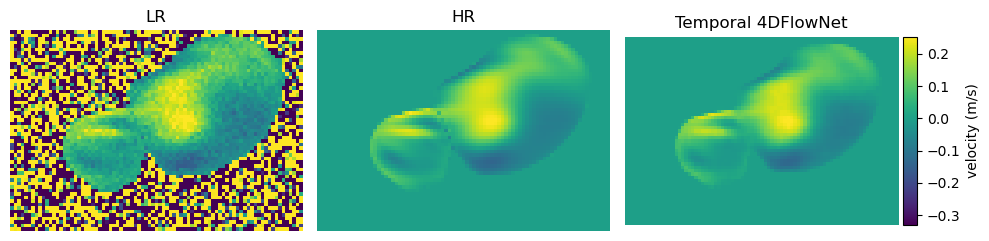

In [19]:
def create_temporal_comparison_gif_plt(idx, lr, hr, pred, vel, title=''):
    N_frames = hr[vel].shape[0]
    N = 4
    v_lr = lr[vel]
    v_hr = hr[vel]
    v_pred = pred[vel]
    v_error_abs= error_absolut[f'{vel}']
    v_NN = temporal_NN_interpolation(v_lr,v_hr.shape )

    err_max = np.quantile(v_error_abs[np.where(dynamic_mask !=0)].flatten(), 0.999)
    #np.max(v_error_abs[1:-1])

    fig = plt.figure(frameon=False)
    

    plt.subplot(1, N, 1)
    im1 = plt.imshow(v_NN[0, idx, :, :],vmin=min_v[vel], vmax=max_v[vel])
    plt.axis('off')
    plt.subplot(1, N, 2)
    im2 = plt.imshow(v_hr[0, idx, :, :],vmin=min_v[vel], vmax=max_v[vel])
    plt.axis('off')
    plt.subplot(1, N, 3)
    im3 = plt.imshow(v_pred[0, idx, :, :],vmin=min_v[vel], vmax=max_v[vel])
    plt.axis('off')

    plt.subplot(1, N, 4)
    ax = plt.gca()
    im4 = ax.imshow(v_error_abs[0, idx, :, :],vmin=0, vmax=err_max)
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im4, cax=cax)
    plt.tight_layout()

    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        im2.set_data(np.random.random((5,5)))
        im3.set_data(np.random.random((5,5)))
        im4.set_data(np.random.random((5,5)))
        return [im1, im2, im3, im4]

    # animation function.  This is called sequentially
    def animate(i):
        
        im1.set_array(v_NN[i, idx, :, :])
        im2.set_array(v_hr[i, idx, :, :])
        im3.set_array(v_pred[i, idx, :, :])
        im4.set_array(v_error_abs[i, idx, :, :])
        
        return [im1, im2, im3, im4]

    anim = animation.FuncAnimation(fig,animate, init_func=init,
                                frames = N_frames - 1,
                                interval = 100) # in ms
    print("Gif is saved under:" f'{eval_dir}/{set_name}_M{data_model}_Animate_{vel}_{title}.gif')
    anim.save(f'{eval_dir}/{set_name}_M{data_model}_Animate_{vel}_{title}.gif', fps=10)

def create_temporal_comp_LR_HR_SR(idx, lr, hr, pred, vel, title):
    N_frames = hr[vel].shape[0]
    N = 3
    v_lr = lr[vel]
    v_hr = hr[vel]
    v_pred = pred[vel]
    # v_NN = temporal_NN_interpolation(v_lr,v_hr.shape )
    v_NN = np.zeros_like(v_hr)
    v_NN[::2] = v_lr
    v_NN[1::2] = v_lr
    print(v_lr.shape, v_NN.shape, v_hr.shape, v_pred.shape)


    fig = plt.figure(frameon=False)
    

    plt.subplot(1, N, 1)
    im1 = plt.imshow(v_NN[0, idx, :, :],vmin=min_v[vel], vmax=max_v[vel])
    plt.axis('off')
    plt.title('LR')
    plt.subplot(1, N, 2)
    im2 = plt.imshow(v_hr[0, idx, :, :],vmin=min_v[vel], vmax=max_v[vel])
    plt.title('HR')
    plt.axis('off')
    plt.subplot(1, N, 3)
    ax = plt.gca()
    im3 = plt.imshow(v_pred[0, idx, :, :],vmin=min_v[vel], vmax=max_v[vel])
    plt.axis('off')
    plt.title('Temporal 4DFlowNet')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05, ) 
    plt.colorbar(im3, cax=cax, label = 'velocity (m/s)')
    plt.tight_layout()

    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        im2.set_data(np.random.random((5,5)))
        im3.set_data(np.random.random((5,5)))
        return [im1, im2, im3]

    # animation function.  This is called sequentially
    def animate(i):
        
        im1.set_array(v_NN[i, idx, :, :])
        im2.set_array(v_hr[i, idx, :, :])
        im3.set_array(v_pred[i, idx, :, :])
        
        return [im1, im2, im3]

    # plt.legend()
    anim = animation.FuncAnimation(fig,animate, init_func=init,           frames = N_frames - 1,                               interval = 100) # in ms
    print("Gif is saved under:" f'{eval_dir}/{set_name}_M{data_model}_Animate_{vel}_HR_SR_LR_{title}.gif')
    anim.save(f'{eval_dir}/{set_name}_M{data_model}_Animate_{vel}__HR_SR_LR_{title}.gif', fps=10)



def create_temporal_comparison_gif_single(idx, data, vel, title):
    N_frames = data.shape[0]
    print(title, 'nframes:', data.shape[0])
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(data[0, idx, :, :],interpolation='none', vmin=min_v[vel], vmax=max_v[vel])
    plt.title(title)
    plt.axis('off')
    
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.tight_layout()

    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        return [im1]

    # animation function.  This is called sequentially
    def animate(i):
        im1.set_array(data[i, idx, :, :])
        # plt.savefig(f'{eval_dir}/Example_{title}_{vel}_{i}.png')
        return [im1]

    anim = animation.FuncAnimation(fig,animate, init_func=init,
                                frames = N_frames,
                                interval = 100) # in ms)
    anim.save(f'{eval_dir}/{set_name}_M{data_model}_Animate_{vel}_{title}_single.gif', fps=30)

    #generate_gif_volume(combined_image[:,idx, :, : ], axis = 0, save_as = save_as)

# create_temporal_comparison_gif_plt(22, lr, gt, pred, "u")
# create_temporal_comparison_gif_plt(22, lr, gt, pred, "v")
# create_temporal_comparison_gif_plt(22, lr, gt, pred, "w")

create_temporal_comp_LR_HR_SR(20, lr, gt, pred, "u", "Test")    

# create_temporal_comparison_gif_plt(22, lr, gt, pred, "speed")
velo = 'v'
# create_temporal_comparison_gif_single(22, lr[velo], velo, "LR")
# create_temporal_comparison_gif_single(22, gt[velo],velo , "HR")
# create_temporal_comparison_gif_single(22, pred[velo],velo, "4DFlowNet")
# create_temporal_comparison_gif_single(22, interpolate_linear[velo], velo, "linear interpoaltion")
# First set up the figure, the axis, and the plot element we want to animate


### Plot correlation lines

In [ ]:

@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1), save = [True, False])
def f_regression(frame=34 , save = False):
    plt.figure(figsize=(15, 5))
    save_as = f'{eval_dir}/{set_name}_M{model_name}_Correlationplt_pred_frame{frame}'
    if not save or save == 'False': save_as = None
    plot_correlation(gt, pred,bounds, frame_idx=frame, save_as=save_as)
    plt.show()

##### Plot correlation for linear and cubic interpolation

In [ ]:

peak_flow_frame = np.argmax(gt['mean_speed'])
# bounds, core_mask = get_boundaries(pred['mask'])
frame_corr_plot = peak_flow_frame.copy()
if frame_corr_plot % 2 == 0: frame_corr_plot +=1 # take next frame if peak flow frame included in lr data

#prediction
plt.figure(figsize=(15, 5))
plot_correlation(gt, pred, bounds=bounds, frame_idx=frame_corr_plot, save_as=f'{eval_dir}/{set_name}_M{model_name}_Correlationplot_pred_frame{frame_corr_plot}.svg')

if include_interpolationfiles:

    #linear interpolation
    plt.figure(figsize=(15, 5))
    plot_correlation(gt, interpolate_linear, bounds=bounds, frame_idx=frame_corr_plot,color_b = KI_colors['Green'],  save_as=f'{eval_dir}/{set_name}_M{model_name}_Correlationplot_linearinterpol_frame{frame_corr_plot}.svg')
    #cubic interpolation
    plt.figure(figsize=(15, 5))
    plot_correlation(gt, interpolate_cubic, bounds=bounds, frame_idx=frame_corr_plot,color_b = 'forestgreen',  save_as=f'{eval_dir}/{set_name}_M{model_name}_Correlationplot_cubicinterpol_framee{frame_corr_plot}.svg')


### Plot k, $R^2$ values over time

In [ ]:
plot_k_r2_vals(gt, pred, bounds, peak_flow_frame,color_b = KI_colors['Plum'] , save_as= f'{eval_dir}/{set_name}_M{model_name}_k_r2_vals_frame{peak_flow_frame}_pred', model_name=model_name, set_name=set_name, eval_dir=eval_dir)
if include_interpolationfiles:
    plot_k_r2_vals(gt, interpolate_linear, bounds, peak_flow_frame,color_b = KI_colors['Green'], save_as= f'{eval_dir}/{set_name}_M{model_name}_k_r2_vals_frame{peak_flow_frame}_linear_interpolation')
    plot_k_r2_vals(gt, interpolate_cubic, bounds, peak_flow_frame,color_b = 'forestgreen', save_as= f'{eval_dir}/{set_name}_M{model_name}_k_r2_vals_frame{peak_flow_frame}_cubic_interpolation')

### Plot velocity of single peak flow voxel over time

In [ ]:
#Params for plot
patch_size = 1
show_avg = True
show_pixel = True

def show_peak_flow_pixel(lr_data, hr_data,pred_data,  patch_size, show_avg, show_pixel):
    plt.figure(figsize=(7, 5))
    idx_max = np.unravel_index(np.argmax(hr_data['speed']), shape = hr_data['speed'].shape)
    x = np.arange(hr_data['speed'].shape[0])
    if show_pixel:
        plt.plot(x, hr_data['speed'][:, idx_max[1], idx_max[2], idx_max[3]]*100,  label = 'ground truth pixel', color = 'black')
        plt.plot(x[0::2], lr['speed'][:, idx_max[1], idx_max[2], idx_max[3]]*100,'-o' ,label = 'low resolution pixel', color= 'yellowgreen')
        plt.plot(x, pred['speed'][:, idx_max[1], idx_max[2], idx_max[3]]*100,'--', label = 'prediction pixel')

    if show_avg:
        plt.plot(x,         np.average(hr_data['speed']  [:, idx_max[1]-patch_size:idx_max[1]+patch_size+1, idx_max[2]-patch_size:idx_max[2]+patch_size+1, idx_max[3]-patch_size:idx_max[3]+patch_size+1], axis = (1, 2, 3))*100,  label = 'ground truth avg', color = 'grey')
        plt.plot(x[0::2],    np.average(lr_data['speed']  [:, idx_max[1]-patch_size:idx_max[1]+patch_size+1, idx_max[2]-patch_size:idx_max[2]+patch_size+1, idx_max[3]-patch_size:idx_max[3]+patch_size+1], axis = (1, 2, 3))*100,'-o' ,label = 'low resolution avg', color = 'olive')
        plt.plot(x,         np.average(pred_data['speed'][:, idx_max[1]-patch_size:idx_max[1]+patch_size+1, idx_max[2]-patch_size:idx_max[2]+patch_size+1, idx_max[3]-patch_size:idx_max[3]+patch_size+1], axis = (1, 2, 3))*100,'--', label = 'prediction avg', color = 'navy' )
    if show_avg:
        plt.title(f"Speed at voxel {idx_max[1::]} with average of number of voxels: {(2*patch_size+1)**3}")
    else:
        plt.title(f"Speed at voxel with index {idx_max[1::]}")
    plt.ylabel('Speed (cm/s)')
    plt.ylabel('Speed (cm/s)')
    plt.xlabel('Frame')
    plt.legend()
    plt.savefig(f'{eval_dir}/{set_name}_M{model_name}_Peak_flow_voxel_pred.svg',bbox_inches='tight')
    plt.show()

show_peak_flow_pixel(lr, gt, pred, patch_size, show_avg, show_pixel)